In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS 
from global_config import RANDOM_SEED, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_losses import precision, recall, f1, specificity 
from custom_losses import negative_predictive_value as npv 
from custom_losses import matthews_correlation_coefficient as mcc

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)
print(FOLDER_MODELS)
print(IMAGE_SIZE)
print(RANDOM_SEED)
print(USER_IDS)

../data/pybossa/pybossa_images.pkl
../data/pybossa/pybossa_mrks.pkl
../models/autoencoders_requirements/
(224, 224)
42
1_2_3_5_6


In [3]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'
FILE_MERGED_MODEL = f'{FOLDER_MODELS}merged_model_{USER_IDS}.h5'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))    

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [5]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [6]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [7]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5349 - accuracy: 0.7015 - precision: 0.9377 - recall: 0.6972 - f1: 0.7915 - specificity: 0.7004 - negative_predictive_value: 0.2497 - matthews_correlation_coefficient: 0.2695 - val_loss: 0.5444 - val_accuracy: 0.6505 - val_precision: 0.9427 - val_recall: 0.6110 - val_f1: 0.7363 - val_specificity: 0.8268 - val_negative_predictive_value: 0.2543 - val_matthews_correlation_coefficient: 0.2904

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29043, saving model to ../models/autoencoders_requirements/blurred_2020_03_29-22_13_39.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5021 - accuracy: 0.7371 - precision: 0.9593 - recall: 0.7377 - f1: 0.8254 - specificity: 0.7227 - negative_predictive_value: 0.2786 - matthews_correlation_coefficient: 0.3223 - val_loss: 0.5180 - val_accuracy: 0.6956 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.44161
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4058 - accuracy: 0.7475 - precision: 0.9768 - recall: 0.7347 - f1: 0.8342 - specificity: 0.8614 - negative_predictive_value: 0.2993 - matthews_correlation_coefficient: 0.3970 - val_loss: 0.4764 - val_accuracy: 0.7771 - val_precision: 0.9438 - val_recall: 0.7543 - val_f1: 0.8350 - val_specificity: 0.7540 - val_negative_predictive_value: 0.3192 - val_matthews_correlation_coefficient: 0.3894

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.44161
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3929 - accuracy: 0.7657 - precision: 0.9794 - recall: 0.7545 - f1: 0.8468 - specificity: 0.8439 - negative_predictive_value: 0.3260 - matthews_correlation_coefficient: 0.4182 - val_loss: 0.3751 - val_accuracy: 0.8248 - val_precision: 0.9339 - val_recall: 0.8172 - val_f1: 0.8696 - val_spe


Epoch 00029: val_matthews_correlation_coefficient improved from 0.44161 to 0.46407, saving model to ../models/autoencoders_requirements/blurred_2020_03_29-22_13_39.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3760 - accuracy: 0.7816 - precision: 0.9785 - recall: 0.7699 - f1: 0.8567 - specificity: 0.8743 - negative_predictive_value: 0.3397 - matthews_correlation_coefficient: 0.4463 - val_loss: 0.4338 - val_accuracy: 0.8014 - val_precision: 0.9490 - val_recall: 0.7760 - val_f1: 0.8510 - val_specificity: 0.8233 - val_negative_predictive_value: 0.3824 - val_matthews_correlation_coefficient: 0.4391

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.46407
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4454 - accuracy: 0.7228 - precision: 0.9706 - recall: 0.7052 - f1: 0.7961 - specificity: 0.8365 - negative_predictive_value: 0.3098 - matthews_correlation_coefficient: 0.3853 - val_loss: 0.4268 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3510 - accuracy: 0.7957 - precision: 0.9835 - recall: 0.7851 - f1: 0.8703 - specificity: 0.8666 - negative_predictive_value: 0.3473 - matthews_correlation_coefficient: 0.4557 - val_loss: 0.3068 - val_accuracy: 0.8664 - val_precision: 0.9264 - val_recall: 0.8734 - val_f1: 0.8975 - val_specificity: 0.6029 - val_negative_predictive_value: 0.4170 - val_matthews_correlation_coefficient: 0.4227

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.47580
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3460 - accuracy: 0.8037 - precision: 0.9852 - recall: 0.7933 - f1: 0.8756 - specificity: 0.8862 - negative_predictive_value: 0.3700 - matthews_correlation_coefficient: 0.4806 - val_loss: 0.3104 - val_accuracy: 0.8517 - val_precision: 0.9274 - val_recall: 0.8547 - val_f1: 0.8878 - val_specificity: 0.6159 - val_negative_predictive_value: 0.3904 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.49735
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3371 - accuracy: 0.8148 - precision: 0.9854 - recall: 0.8047 - f1: 0.8828 - specificity: 0.8940 - negative_predictive_value: 0.3776 - matthews_correlation_coefficient: 0.4944 - val_loss: 0.3627 - val_accuracy: 0.8274 - val_precision: 0.9454 - val_recall: 0.8103 - val_f1: 0.8704 - val_specificity: 0.7517 - val_negative_predictive_value: 0.3792 - val_matthews_correlation_coefficient: 0.4466

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.49735
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3366 - accuracy: 0.8102 - precision: 0.9813 - recall: 0.8003 - f1: 0.8781 - specificity: 0.8907 - negative_predictive_value: 0.3691 - matthews_correlation_coefficient: 0.4857 - val_loss: 0.3627 - val_accuracy: 0.8604 - val_precision: 0.9425 - val_recall: 0.8484 - val_f1: 0.8914 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.50459
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3186 - accuracy: 0.8297 - precision: 0.9867 - recall: 0.8209 - f1: 0.8939 - specificity: 0.8937 - negative_predictive_value: 0.3937 - matthews_correlation_coefficient: 0.5104 - val_loss: 0.3019 - val_accuracy: 0.8794 - val_precision: 0.9321 - val_recall: 0.8810 - val_f1: 0.9045 - val_specificity: 0.6495 - val_negative_predictive_value: 0.4592 - val_matthews_correlation_coefficient: 0.4701

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.50459
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3225 - accuracy: 0.8297 - precision: 0.9814 - recall: 0.8227 - f1: 0.8921 - specificity: 0.8951 - negative_predictive_value: 0.4013 - matthews_correlation_coefficient: 0.5170 - val_loss: 0.3176 - val_accuracy: 0.8664 - val_precision: 0.9382 - val_recall: 0.8600 - val_f1: 0.8957 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3289 - accuracy: 0.8200 - precision: 0.9842 - recall: 0.8109 - f1: 0.8862 - specificity: 0.8837 - negative_predictive_value: 0.3858 - matthews_correlation_coefficient: 0.4970 - val_loss: 0.3563 - val_accuracy: 0.8647 - val_precision: 0.9401 - val_recall: 0.8559 - val_f1: 0.8941 - val_specificity: 0.7462 - val_negative_predictive_value: 0.4870 - val_matthews_correlation_coefficient: 0.4921

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.51667
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3120 - accuracy: 0.8410 - precision: 0.9831 - recall: 0.8369 - f1: 0.9021 - specificity: 0.8923 - negative_predictive_value: 0.4149 - matthews_correlation_coefficient: 0.5282 - val_loss: 0.3850 - val_accuracy: 0.8395 - val_precision: 0.9489 - val_recall: 0.8185 - val_f1: 0.8768 - val_specificity: 0.8150 - val_negative_predictive_value: 0.4421 - val_matthews_correlation_coefficie

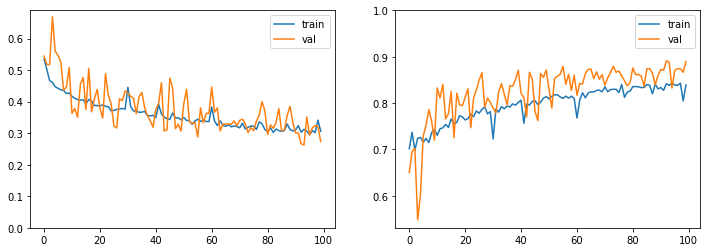

In [8]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6698 - accuracy: 0.5922 - precision: 0.7749 - recall: 0.5870 - f1: 0.6465 - specificity: 0.5993 - negative_predictive_value: 0.3916 - matthews_correlation_coefficient: 0.1812 - val_loss: 0.6212 - val_accuracy: 0.6670 - val_precision: 0.7476 - val_recall: 0.7189 - val_f1: 0.7286 - val_specificity: 0.5194 - val_negative_predictive_value: 0.4785 - val_matthews_correlation_coefficient: 0.2314

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.23140, saving model to ../models/autoencoders_requirements/looking_away_2020_03_29-22_28_37.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6613 - accuracy: 0.6193 - precision: 0.7742 - recall: 0.6220 - f1: 0.6777 - specificity: 0.6097 - negative_predictive_value: 0.4325 - matthews_correlation_coefficient: 0.2197 - val_loss: 0.6768 - val_accuracy: 0.5759 - val_precision


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.34620
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6082 - accuracy: 0.6742 - precision: 0.8248 - recall: 0.6718 - f1: 0.7308 - specificity: 0.6795 - negative_predictive_value: 0.4919 - matthews_correlation_coefficient: 0.3336 - val_loss: 0.5841 - val_accuracy: 0.6869 - val_precision: 0.7619 - val_recall: 0.7405 - val_f1: 0.7460 - val_specificity: 0.5169 - val_negative_predictive_value: 0.4900 - val_matthews_correlation_coefficient: 0.2800

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.34620
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6072 - accuracy: 0.6848 - precision: 0.8212 - recall: 0.6988 - f1: 0.7475 - specificity: 0.6581 - negative_predictive_value: 0.5055 - matthews_correlation_coefficient: 0.3400 - val_loss: 0.5557 - val_accuracy: 0.7069 - val_precision: 0.7716 - val_recall: 0.7596 - val_f1: 0.7602 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5776 - accuracy: 0.7035 - precision: 0.8331 - recall: 0.7194 - f1: 0.7650 - specificity: 0.6802 - negative_predictive_value: 0.5295 - matthews_correlation_coefficient: 0.3793 - val_loss: 0.6359 - val_accuracy: 0.6808 - val_precision: 0.8278 - val_recall: 0.6303 - val_f1: 0.7097 - val_specificity: 0.7590 - val_negative_predictive_value: 0.5096 - val_matthews_correlation_coefficient: 0.3614

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.40428
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5779 - accuracy: 0.7052 - precision: 0.8379 - recall: 0.7128 - f1: 0.7642 - specificity: 0.6957 - negative_predictive_value: 0.5276 - matthews_correlation_coefficient: 0.3854 - val_loss: 0.5845 - val_accuracy: 0.6921 - val_precision: 0.8223 - val_recall: 0.6600 - val_f1: 0.7281 - val_specificity: 0.7284 - val_negative_predictive_value: 0.5154 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.42025
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5611 - accuracy: 0.7082 - precision: 0.8431 - recall: 0.7164 - f1: 0.7678 - specificity: 0.7053 - negative_predictive_value: 0.5317 - matthews_correlation_coefficient: 0.3962 - val_loss: 0.7892 - val_accuracy: 0.5768 - val_precision: 0.8423 - val_recall: 0.4422 - val_f1: 0.5739 - val_specificity: 0.8548 - val_negative_predictive_value: 0.4316 - val_matthews_correlation_coefficient: 0.2838

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.42025
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5603 - accuracy: 0.7087 - precision: 0.8483 - recall: 0.7048 - f1: 0.7621 - specificity: 0.7249 - negative_predictive_value: 0.5397 - matthews_correlation_coefficient: 0.4068 - val_loss: 0.5529 - val_accuracy: 0.7051 - val_precision: 0.7927 - val_recall: 0.7244 - val_f1: 0.7520 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.42025
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5463 - accuracy: 0.7236 - precision: 0.8434 - recall: 0.7381 - f1: 0.7816 - specificity: 0.6987 - negative_predictive_value: 0.5500 - matthews_correlation_coefficient: 0.4132 - val_loss: 0.6190 - val_accuracy: 0.6713 - val_precision: 0.8349 - val_recall: 0.6052 - val_f1: 0.6968 - val_specificity: 0.7866 - val_negative_predictive_value: 0.4986 - val_matthews_correlation_coefficient: 0.3605

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.42025
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5491 - accuracy: 0.7193 - precision: 0.8438 - recall: 0.7183 - f1: 0.7689 - specificity: 0.7153 - negative_predictive_value: 0.5453 - matthews_correlation_coefficient: 0.4108 - val_loss: 0.7080 - val_accuracy: 0.6080 - val_precision: 0.8492 - val_recall: 0.4862 - val_f1: 0.6127 - val_spe

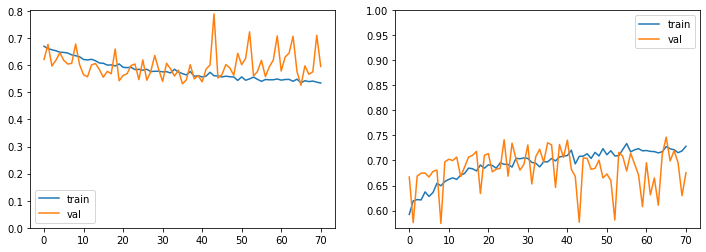

In [9]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

In [10]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

the requirement ink_marked_creased has only one label.


#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6342 - accuracy: 0.6462 - precision: 0.6874 - recall: 0.6450 - f1: 0.6438 - specificity: 0.6453 - negative_predictive_value: 0.6147 - matthews_correlation_coefficient: 0.2996 - val_loss: 0.6203 - val_accuracy: 0.6435 - val_precision: 0.7532 - val_recall: 0.5824 - val_f1: 0.6476 - val_specificity: 0.7221 - val_negative_predictive_value: 0.5542 - val_matthews_correlation_coefficient: 0.3053

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.30529, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_29-22_39_14.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6050 - accuracy: 0.6794 - precision: 0.7236 - recall: 0.7152 - f1: 0.7031 - specificity: 0.6367 - negative_predictive_value: 0.6537 - matthews_correlation_coefficient: 0.3630 - val_loss: 0.5600 - val_accuracy: 0.7511 - val_pr


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.53426
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4973 - accuracy: 0.7610 - precision: 0.7516 - recall: 0.8456 - f1: 0.7916 - specificity: 0.6479 - negative_predictive_value: 0.7729 - matthews_correlation_coefficient: 0.5097 - val_loss: 0.4800 - val_accuracy: 0.7736 - val_precision: 0.7768 - val_recall: 0.8627 - val_f1: 0.8131 - val_specificity: 0.6445 - val_negative_predictive_value: 0.7573 - val_matthews_correlation_coefficient: 0.5200

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.53426
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4908 - accuracy: 0.7651 - precision: 0.7692 - recall: 0.8401 - f1: 0.7960 - specificity: 0.6675 - negative_predictive_value: 0.7648 - matthews_correlation_coefficient: 0.5218 - val_loss: 0.4716 - val_accuracy: 0.7832 - val_precision: 0.7841 - val_recall: 0.8653 - val_f1: 0.8186 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4559 - accuracy: 0.7829 - precision: 0.7876 - recall: 0.8438 - f1: 0.8078 - specificity: 0.7112 - negative_predictive_value: 0.7740 - matthews_correlation_coefficient: 0.5591 - val_loss: 0.4605 - val_accuracy: 0.7806 - val_precision: 0.7656 - val_recall: 0.8208 - val_f1: 0.7877 - val_specificity: 0.6845 - val_negative_predictive_value: 0.7540 - val_matthews_correlation_coefficient: 0.5389

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.56152
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4497 - accuracy: 0.7913 - precision: 0.7996 - recall: 0.8491 - f1: 0.8182 - specificity: 0.7182 - negative_predictive_value: 0.7854 - matthews_correlation_coefficient: 0.5756 - val_loss: 0.4514 - val_accuracy: 0.7892 - val_precision: 0.7873 - val_recall: 0.8754 - val_f1: 0.8248 - val_specificity: 0.6634 - val_negative_predictive_value: 0.7808 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.56252
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4417 - accuracy: 0.7935 - precision: 0.7959 - recall: 0.8417 - f1: 0.8135 - specificity: 0.7272 - negative_predictive_value: 0.7908 - matthews_correlation_coefficient: 0.5791 - val_loss: 0.4804 - val_accuracy: 0.7693 - val_precision: 0.8000 - val_recall: 0.8035 - val_f1: 0.7976 - val_specificity: 0.7169 - val_negative_predictive_value: 0.7141 - val_matthews_correlation_coefficient: 0.5170

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.56252
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4368 - accuracy: 0.7957 - precision: 0.8133 - recall: 0.8365 - f1: 0.8173 - specificity: 0.7423 - negative_predictive_value: 0.7789 - matthews_correlation_coefficient: 0.5867 - val_loss: 0.4499 - val_accuracy: 0.7979 - val_precision: 0.7962 - val_recall: 0.8818 - val_f1: 0.8322 - val_spe


Epoch 00058: val_matthews_correlation_coefficient improved from 0.57308 to 0.57567, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_29-22_39_14.h5
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4260 - accuracy: 0.8046 - precision: 0.8114 - recall: 0.8512 - f1: 0.8258 - specificity: 0.7416 - negative_predictive_value: 0.7930 - matthews_correlation_coefficient: 0.5998 - val_loss: 0.4635 - val_accuracy: 0.7736 - val_precision: 0.8002 - val_recall: 0.7507 - val_f1: 0.7688 - val_specificity: 0.7665 - val_negative_predictive_value: 0.7057 - val_matthews_correlation_coefficient: 0.5383

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.57567
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4329 - accuracy: 0.7918 - precision: 0.8122 - recall: 0.8285 - f1: 0.8139 - specificity: 0.7428 - negative_predictive_value: 0.7685 - matthews_correlation_coefficient: 0.5755 - val_loss: 0


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.57567
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4331 - accuracy: 0.8004 - precision: 0.8130 - recall: 0.8310 - f1: 0.8141 - specificity: 0.7595 - negative_predictive_value: 0.7880 - matthews_correlation_coefficient: 0.5968 - val_loss: 0.5331 - val_accuracy: 0.7415 - val_precision: 0.7928 - val_recall: 0.6855 - val_f1: 0.7310 - val_specificity: 0.7734 - val_negative_predictive_value: 0.6521 - val_matthews_correlation_coefficient: 0.4786

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.57567
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4358 - accuracy: 0.7965 - precision: 0.8145 - recall: 0.8191 - f1: 0.8105 - specificity: 0.7560 - negative_predictive_value: 0.7713 - matthews_correlation_coefficient: 0.5867 - val_loss: 0.4413 - val_accuracy: 0.7988 - val_precision: 0.8149 - val_recall: 0.8451 - val_f1: 0.8257 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.58328
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4107 - accuracy: 0.8093 - precision: 0.8297 - recall: 0.8383 - f1: 0.8272 - specificity: 0.7688 - negative_predictive_value: 0.7841 - matthews_correlation_coefficient: 0.6117 - val_loss: 0.4620 - val_accuracy: 0.7823 - val_precision: 0.8048 - val_recall: 0.7561 - val_f1: 0.7753 - val_specificity: 0.7748 - val_negative_predictive_value: 0.7129 - val_matthews_correlation_coefficient: 0.5511

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.58328
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4129 - accuracy: 0.8102 - precision: 0.8238 - recall: 0.8455 - f1: 0.8285 - specificity: 0.7647 - negative_predictive_value: 0.7902 - matthews_correlation_coefficient: 0.6132 - val_loss: 0.4538 - val_accuracy: 0.7840 - val_precision: 0.7829 - val_recall: 0.7944 - val_f1: 0.7839 - val_spe

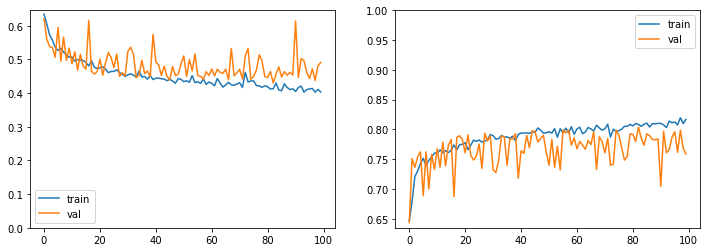

In [11]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5697 - accuracy: 0.7239 - precision: 0.9629 - recall: 0.7223 - f1: 0.8089 - specificity: 0.6522 - negative_predictive_value: 0.2003 - matthews_correlation_coefficient: 0.2539 - val_loss: 0.8350 - val_accuracy: 0.4510 - val_precision: 0.9647 - val_recall: 0.3950 - val_f1: 0.5551 - val_specificity: 0.9189 - val_negative_predictive_value: 0.1433 - val_matthews_correlation_coefficient: 0.1848

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.18480, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_29-22_54_02.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4490 - accuracy: 0.7879 - precision: 0.9839 - recall: 0.7860 - f1: 0.8661 - specificity: 0.8349 - negative_predictive_value: 0.2904 - matthews_correlation_coefficient: 0.4008 - val_loss: 0.4910 - val_accuracy: 0.7771 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3324 - accuracy: 0.8651 - precision: 0.9860 - recall: 0.8672 - f1: 0.9212 - specificity: 0.8067 - negative_predictive_value: 0.3602 - matthews_correlation_coefficient: 0.4733 - val_loss: 0.3526 - val_accuracy: 0.8517 - val_precision: 0.9548 - val_recall: 0.8315 - val_f1: 0.8872 - val_specificity: 0.7702 - val_negative_predictive_value: 0.3381 - val_matthews_correlation_coefficient: 0.4124

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.44189
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3639 - accuracy: 0.8512 - precision: 0.9837 - recall: 0.8544 - f1: 0.9117 - specificity: 0.7800 - negative_predictive_value: 0.3494 - matthews_correlation_coefficient: 0.4512 - val_loss: 0.3549 - val_accuracy: 0.8604 - val_precision: 0.9531 - val_recall: 0.8430 - val_f1: 0.8931 - val_specificity: 0.7716 - val_negative_predictive_value: 0.3620 - val_matthews_correlation_coefficie


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.46512
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2943 - accuracy: 0.8777 - precision: 0.9893 - recall: 0.8748 - f1: 0.9268 - specificity: 0.8242 - negative_predictive_value: 0.3939 - matthews_correlation_coefficient: 0.5101 - val_loss: 0.4197 - val_accuracy: 0.8239 - val_precision: 0.9563 - val_recall: 0.8009 - val_f1: 0.8698 - val_specificity: 0.8146 - val_negative_predictive_value: 0.3118 - val_matthews_correlation_coefficient: 0.3992

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.46512
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2851 - accuracy: 0.8772 - precision: 0.9893 - recall: 0.8776 - f1: 0.9288 - specificity: 0.8153 - negative_predictive_value: 0.3809 - matthews_correlation_coefficient: 0.4975 - val_loss: 0.4876 - val_accuracy: 0.7884 - val_precision: 0.9592 - val_recall: 0.7606 - val_f1: 0.8459 - val_spe


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.46512
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2800 - accuracy: 0.8714 - precision: 0.9883 - recall: 0.8723 - f1: 0.9249 - specificity: 0.8263 - negative_predictive_value: 0.3757 - matthews_correlation_coefficient: 0.4938 - val_loss: 0.3556 - val_accuracy: 0.8500 - val_precision: 0.9559 - val_recall: 0.8288 - val_f1: 0.8860 - val_specificity: 0.7959 - val_negative_predictive_value: 0.3508 - val_matthews_correlation_coefficient: 0.4290

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.46512
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2744 - accuracy: 0.8909 - precision: 0.9887 - recall: 0.8931 - f1: 0.9370 - specificity: 0.8163 - negative_predictive_value: 0.4279 - matthews_correlation_coefficient: 0.5333 - val_loss: 0.4404 - val_accuracy: 0.8066 - val_precision: 0.9560 - val_recall: 0.7818 - val_f1: 0.8581 - val_spe

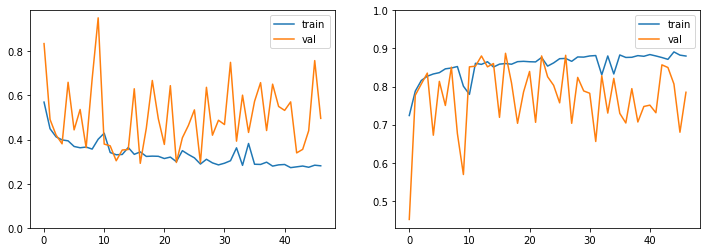

In [12]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5836 - accuracy: 0.7993 - precision: 0.9965 - recall: 0.8027 - f1: 0.8810 - specificity: 0.1345 - negative_predictive_value: 0.0358 - matthews_correlation_coefficient: 0.0531 - val_loss: 0.3934 - val_accuracy: 0.7450 - val_precision: 1.0000 - val_recall: 0.7494 - val_f1: 0.8547 - val_specificity: 0.2162 - val_negative_predictive_value: 0.0308 - val_matthews_correlation_coefficient: 0.0695

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.06948, saving model to ../models/autoencoders_requirements/washed_out_2020_03_29-23_01_11.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4171 - accuracy: 0.7510 - precision: 0.9982 - recall: 0.7518 - f1: 0.8480 - specificity: 0.1759 - negative_predictive_value: 0.0326 - matthews_correlation_coefficient: 0.0572 - val_loss: 0.1254 - val_accuracy: 0.9792 - val_precision: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.0811 - accuracy: 0.9705 - precision: 0.9998 - recall: 0.9706 - f1: 0.9843 - specificity: 0.2310 - negative_predictive_value: 0.1708 - matthews_correlation_coefficient: 0.1905 - val_loss: 0.0675 - val_accuracy: 0.9775 - val_precision: 1.0000 - val_recall: 0.9779 - val_f1: 0.9886 - val_specificity: 0.2162 - val_negative_predictive_value: 0.1622 - val_matthews_correlation_coefficient: 0.1825

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.18621
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0988 - accuracy: 0.9642 - precision: 0.9996 - recall: 0.9645 - f1: 0.9809 - specificity: 0.2414 - negative_predictive_value: 0.1611 - matthews_correlation_coefficient: 0.1860 - val_loss: 0.2477 - val_accuracy: 0.9020 - val_precision: 1.0000 - val_recall: 0.9035 - val_f1: 0.9483 - val_specificity: 0.2162 - val_negative_predictive_value: 0.0679 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.19443
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0767 - accuracy: 0.9711 - precision: 0.9998 - recall: 0.9713 - f1: 0.9850 - specificity: 0.2345 - negative_predictive_value: 0.1439 - matthews_correlation_coefficient: 0.1770 - val_loss: 0.0371 - val_accuracy: 0.9879 - val_precision: 1.0000 - val_recall: 0.9881 - val_f1: 0.9939 - val_specificity: 0.2162 - val_negative_predictive_value: 0.1802 - val_matthews_correlation_coefficient: 0.1944

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.19443
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1062 - accuracy: 0.9538 - precision: 0.9998 - recall: 0.9539 - f1: 0.9748 - specificity: 0.2172 - negative_predictive_value: 0.1544 - matthews_correlation_coefficient: 0.1733 - val_loss: 0.0164 - val_accuracy: 0.9957 - val_precision: 1.0000 - val_recall: 0.9957 - val_f1: 0.9978 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.19976
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0697 - accuracy: 0.9644 - precision: 0.9998 - recall: 0.9614 - f1: 0.9791 - specificity: 0.2552 - negative_predictive_value: 0.1618 - matthews_correlation_coefficient: 0.1950 - val_loss: 0.1274 - val_accuracy: 0.9601 - val_precision: 1.0000 - val_recall: 0.9607 - val_f1: 0.9796 - val_specificity: 0.2162 - val_negative_predictive_value: 0.1261 - val_matthews_correlation_coefficient: 0.1585

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.19976
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0613 - accuracy: 0.9696 - precision: 1.0000 - recall: 0.9696 - f1: 0.9842 - specificity: 0.2276 - negative_predictive_value: 0.1705 - matthews_correlation_coefficient: 0.1910 - val_loss: 0.0503 - val_accuracy: 0.9844 - val_precision: 1.0000 - val_recall: 0.9847 - val_f1: 0.9922 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.19976
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0367 - accuracy: 0.9798 - precision: 1.0000 - recall: 0.9798 - f1: 0.9897 - specificity: 0.2414 - negative_predictive_value: 0.1822 - matthews_correlation_coefficient: 0.2049 - val_loss: 0.0573 - val_accuracy: 0.9818 - val_precision: 1.0000 - val_recall: 0.9820 - val_f1: 0.9908 - val_specificity: 0.2162 - val_negative_predictive_value: 0.1441 - val_matthews_correlation_coefficient: 0.1726

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.19976
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0303 - accuracy: 0.9829 - precision: 1.0000 - recall: 0.9829 - f1: 0.9912 - specificity: 0.2483 - negative_predictive_value: 0.2000 - matthews_correlation_coefficient: 0.2181 - val_loss: 0.0256 - val_accuracy: 0.9939 - val_precision: 1.0000 - val_recall: 0.9940 - val_f1: 0.9969 - val_spe

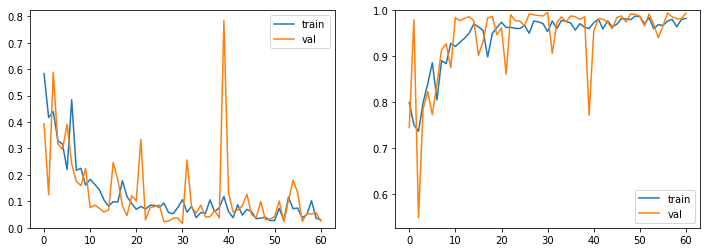

In [13]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6716 - accuracy: 0.5447 - precision: 0.9407 - recall: 0.5355 - f1: 0.6655 - specificity: 0.6054 - negative_predictive_value: 0.1041 - matthews_correlation_coefficient: 0.1124 - val_loss: 0.7307 - val_accuracy: 0.4866 - val_precision: 0.9718 - val_recall: 0.4753 - val_f1: 0.6302 - val_specificity: 0.6941 - val_negative_predictive_value: 0.0970 - val_matthews_correlation_coefficient: 0.1198

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.11977, saving model to ../models/autoencoders_requirements/pixelation_2020_03_29-23_10_21.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6540 - accuracy: 0.5837 - precision: 0.9640 - recall: 0.5788 - f1: 0.7087 - specificity: 0.5994 - negative_predictive_value: 0.1070 - matthews_correlation_coefficient: 0.1252 - val_loss: 0.5472 - val_accuracy: 0.7155 - val_precision: 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.21770
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5176 - accuracy: 0.7189 - precision: 0.9766 - recall: 0.7175 - f1: 0.8240 - specificity: 0.6800 - negative_predictive_value: 0.1668 - matthews_correlation_coefficient: 0.2405 - val_loss: 0.4234 - val_accuracy: 0.7572 - val_precision: 0.9656 - val_recall: 0.7715 - val_f1: 0.8557 - val_specificity: 0.5293 - val_negative_predictive_value: 0.1530 - val_matthews_correlation_coefficient: 0.1910

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.21770
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5257 - accuracy: 0.7041 - precision: 0.9760 - recall: 0.7025 - f1: 0.8137 - specificity: 0.6793 - negative_predictive_value: 0.1566 - matthews_correlation_coefficient: 0.2274 - val_loss: 0.3103 - val_accuracy: 0.8612 - val_precision: 0.9575 - val_recall: 0.8936 - val_f1: 0.9236 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.22350
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4979 - accuracy: 0.7258 - precision: 0.9782 - recall: 0.7249 - f1: 0.8284 - specificity: 0.6866 - negative_predictive_value: 0.1779 - matthews_correlation_coefficient: 0.2533 - val_loss: 0.3663 - val_accuracy: 0.7936 - val_precision: 0.9665 - val_recall: 0.8107 - val_f1: 0.8798 - val_specificity: 0.5225 - val_negative_predictive_value: 0.1796 - val_matthews_correlation_coefficient: 0.2220

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.22350
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4837 - accuracy: 0.7156 - precision: 0.9809 - recall: 0.7113 - f1: 0.8201 - specificity: 0.7253 - negative_predictive_value: 0.1722 - matthews_correlation_coefficient: 0.2580 - val_loss: 0.2508 - val_accuracy: 0.9098 - val_precision: 0.9532 - val_recall: 0.9514 - val_f1: 0.9519 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.24787
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4806 - accuracy: 0.7239 - precision: 0.9813 - recall: 0.7165 - f1: 0.8245 - specificity: 0.7225 - negative_predictive_value: 0.1707 - matthews_correlation_coefficient: 0.2591 - val_loss: 0.3297 - val_accuracy: 0.8387 - val_precision: 0.9596 - val_recall: 0.8657 - val_f1: 0.9094 - val_specificity: 0.4104 - val_negative_predictive_value: 0.1898 - val_matthews_correlation_coefficient: 0.2029

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.24787
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4821 - accuracy: 0.7267 - precision: 0.9738 - recall: 0.7167 - f1: 0.8228 - specificity: 0.6920 - negative_predictive_value: 0.1746 - matthews_correlation_coefficient: 0.2513 - val_loss: 0.5059 - val_accuracy: 0.7016 - val_precision: 0.9681 - val_recall: 0.7102 - val_f1: 0.8167 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.24787
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4627 - accuracy: 0.7406 - precision: 0.9817 - recall: 0.7372 - f1: 0.8396 - specificity: 0.7459 - negative_predictive_value: 0.1894 - matthews_correlation_coefficient: 0.2847 - val_loss: 0.3897 - val_accuracy: 0.7572 - val_precision: 0.9658 - val_recall: 0.7717 - val_f1: 0.8561 - val_specificity: 0.5329 - val_negative_predictive_value: 0.1531 - val_matthews_correlation_coefficient: 0.1912

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.24787
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4684 - accuracy: 0.7223 - precision: 0.9819 - recall: 0.7182 - f1: 0.8240 - specificity: 0.6791 - negative_predictive_value: 0.1789 - matthews_correlation_coefficient: 0.2580 - val_loss: 0.3851 - val_accuracy: 0.7771 - val_precision: 0.9699 - val_recall: 0.7894 - val_f1: 0.8686 - val_spe

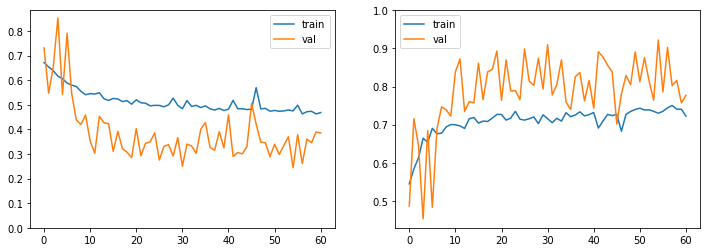

In [14]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5627 - accuracy: 0.6829 - precision: 0.9439 - recall: 0.6568 - f1: 0.7642 - specificity: 0.8081 - negative_predictive_value: 0.3359 - matthews_correlation_coefficient: 0.3561 - val_loss: 0.5153 - val_accuracy: 0.6791 - val_precision: 0.9492 - val_recall: 0.6521 - val_f1: 0.7697 - val_specificity: 0.8272 - val_negative_predictive_value: 0.3271 - val_matthews_correlation_coefficient: 0.3607

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.36069, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_29-23_19_28.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5351 - accuracy: 0.6894 - precision: 0.9558 - recall: 0.6531 - f1: 0.7719 - specificity: 0.8362 - negative_predictive_value: 0.3431 - matthews_correlation_coefficient: 0.3803 - val_loss: 0.5217 - val_accuracy: 0.6722 - val_preci


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.37777
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4991 - accuracy: 0.7273 - precision: 0.9551 - recall: 0.7013 - f1: 0.8032 - specificity: 0.8334 - negative_predictive_value: 0.3848 - matthews_correlation_coefficient: 0.4237 - val_loss: 0.5299 - val_accuracy: 0.6999 - val_precision: 0.9448 - val_recall: 0.6824 - val_f1: 0.7892 - val_specificity: 0.7947 - val_negative_predictive_value: 0.3413 - val_matthews_correlation_coefficient: 0.3665

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.37777
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4874 - accuracy: 0.7553 - precision: 0.9534 - recall: 0.7397 - f1: 0.8279 - specificity: 0.8198 - negative_predictive_value: 0.4097 - matthews_correlation_coefficient: 0.4469 - val_loss: 0.5903 - val_accuracy: 0.6904 - val_precision: 0.9515 - val_recall: 0.6645 - val_f1: 0.7787 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4855 - accuracy: 0.7512 - precision: 0.9488 - recall: 0.7409 - f1: 0.8279 - specificity: 0.8142 - negative_predictive_value: 0.4058 - matthews_correlation_coefficient: 0.4389 - val_loss: 0.4073 - val_accuracy: 0.8049 - val_precision: 0.9133 - val_recall: 0.8484 - val_f1: 0.8788 - val_specificity: 0.5791 - val_negative_predictive_value: 0.4366 - val_matthews_correlation_coefficient: 0.3850

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.39982
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4705 - accuracy: 0.7655 - precision: 0.9509 - recall: 0.7537 - f1: 0.8369 - specificity: 0.8030 - negative_predictive_value: 0.4217 - matthews_correlation_coefficient: 0.4515 - val_loss: 0.5872 - val_accuracy: 0.6895 - val_precision: 0.9464 - val_recall: 0.6691 - val_f1: 0.7805 - val_specificity: 0.8073 - val_negative_predictive_value: 0.3325 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4683 - accuracy: 0.7631 - precision: 0.9506 - recall: 0.7555 - f1: 0.8375 - specificity: 0.8185 - negative_predictive_value: 0.4261 - matthews_correlation_coefficient: 0.4609 - val_loss: 0.5186 - val_accuracy: 0.7259 - val_precision: 0.9382 - val_recall: 0.7217 - val_f1: 0.8133 - val_specificity: 0.7582 - val_negative_predictive_value: 0.3594 - val_matthews_correlation_coefficient: 0.3746

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39982
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4547 - accuracy: 0.7709 - precision: 0.9542 - recall: 0.7590 - f1: 0.8408 - specificity: 0.8284 - negative_predictive_value: 0.4307 - matthews_correlation_coefficient: 0.4714 - val_loss: 0.4772 - val_accuracy: 0.7554 - val_precision: 0.9353 - val_recall: 0.7625 - val_f1: 0.8377 - val_specificity: 0.7264 - val_negative_predictive_value: 0.3856 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.41545
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4551 - accuracy: 0.7668 - precision: 0.9522 - recall: 0.7570 - f1: 0.8387 - specificity: 0.8370 - negative_predictive_value: 0.4327 - matthews_correlation_coefficient: 0.4706 - val_loss: 0.5410 - val_accuracy: 0.7233 - val_precision: 0.9410 - val_recall: 0.7171 - val_f1: 0.8110 - val_specificity: 0.7726 - val_negative_predictive_value: 0.3593 - val_matthews_correlation_coefficient: 0.3800

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.41545
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4487 - accuracy: 0.7683 - precision: 0.9563 - recall: 0.7563 - f1: 0.8412 - specificity: 0.8411 - negative_predictive_value: 0.4276 - matthews_correlation_coefficient: 0.4731 - val_loss: 0.5113 - val_accuracy: 0.7415 - val_precision: 0.9335 - val_recall: 0.7470 - val_f1: 0.8274 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.41664
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4473 - accuracy: 0.7725 - precision: 0.9554 - recall: 0.7625 - f1: 0.8441 - specificity: 0.8283 - negative_predictive_value: 0.4319 - matthews_correlation_coefficient: 0.4732 - val_loss: 0.5785 - val_accuracy: 0.6843 - val_precision: 0.9529 - val_recall: 0.6588 - val_f1: 0.7758 - val_specificity: 0.8245 - val_negative_predictive_value: 0.3297 - val_matthews_correlation_coefficient: 0.3663

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.41664
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4363 - accuracy: 0.7753 - precision: 0.9564 - recall: 0.7601 - f1: 0.8434 - specificity: 0.8263 - negative_predictive_value: 0.4311 - matthews_correlation_coefficient: 0.4728 - val_loss: 0.4891 - val_accuracy: 0.7459 - val_precision: 0.9334 - val_recall: 0.7531 - val_f1: 0.8314 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.41664
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4332 - accuracy: 0.7748 - precision: 0.9514 - recall: 0.7665 - f1: 0.8437 - specificity: 0.8232 - negative_predictive_value: 0.4382 - matthews_correlation_coefficient: 0.4749 - val_loss: 0.4516 - val_accuracy: 0.7459 - val_precision: 0.9371 - val_recall: 0.7500 - val_f1: 0.8310 - val_specificity: 0.7391 - val_negative_predictive_value: 0.3745 - val_matthews_correlation_coefficient: 0.3870

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.41664
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4392 - accuracy: 0.7636 - precision: 0.9535 - recall: 0.7404 - f1: 0.8288 - specificity: 0.8517 - negative_predictive_value: 0.4279 - matthews_correlation_coefficient: 0.4698 - val_loss: 0.5374 - val_accuracy: 0.7190 - val_precision: 0.9431 - val_recall: 0.7095 - val_f1: 0.8071 - val_spe

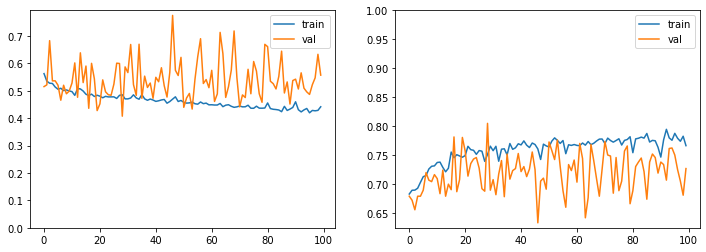

In [15]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6338 - accuracy: 0.5347 - precision: 0.9124 - recall: 0.4619 - f1: 0.6048 - specificity: 0.8130 - negative_predictive_value: 0.2852 - matthews_correlation_coefficient: 0.2321 - val_loss: 0.6765 - val_accuracy: 0.4822 - val_precision: 0.9294 - val_recall: 0.3910 - val_f1: 0.5391 - val_specificity: 0.8689 - val_negative_predictive_value: 0.2668 - val_matthews_correlation_coefficient: 0.2239

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.22389, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_29-23_34_18.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6274 - accuracy: 0.5284 - precision: 0.9218 - recall: 0.4438 - f1: 0.5910 - specificity: 0.8390 - negative_predictive_value: 0.2837 - matthews_correlation_coefficient: 0.2411 - val_loss: 0.6123 - val_accuracy: 0.5343 - val_precision


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.34514
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5800 - accuracy: 0.6386 - precision: 0.9236 - recall: 0.5977 - f1: 0.7180 - specificity: 0.7912 - negative_predictive_value: 0.3467 - matthews_correlation_coefficient: 0.3246 - val_loss: 0.6290 - val_accuracy: 0.6271 - val_precision: 0.9364 - val_recall: 0.5809 - val_f1: 0.7104 - val_specificity: 0.8174 - val_negative_predictive_value: 0.3296 - val_matthews_correlation_coefficient: 0.3235

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.34514
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5725 - accuracy: 0.6725 - precision: 0.9186 - recall: 0.6469 - f1: 0.7517 - specificity: 0.7582 - negative_predictive_value: 0.3612 - matthews_correlation_coefficient: 0.3354 - val_loss: 0.5501 - val_accuracy: 0.6756 - val_precision: 0.9141 - val_recall: 0.6642 - val_f1: 0.7633 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5422 - accuracy: 0.6918 - precision: 0.9228 - recall: 0.6686 - f1: 0.7673 - specificity: 0.7662 - negative_predictive_value: 0.3885 - matthews_correlation_coefficient: 0.3678 - val_loss: 0.5609 - val_accuracy: 0.6765 - val_precision: 0.9119 - val_recall: 0.6666 - val_f1: 0.7651 - val_specificity: 0.7180 - val_negative_predictive_value: 0.3513 - val_matthews_correlation_coefficient: 0.3163

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.35845
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5440 - accuracy: 0.6913 - precision: 0.9158 - recall: 0.6641 - f1: 0.7620 - specificity: 0.7891 - negative_predictive_value: 0.3947 - matthews_correlation_coefficient: 0.3708 - val_loss: 0.5932 - val_accuracy: 0.6765 - val_precision: 0.9231 - val_recall: 0.6578 - val_f1: 0.7633 - val_specificity: 0.7531 - val_negative_predictive_value: 0.3554 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.36887
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5367 - accuracy: 0.6950 - precision: 0.9113 - recall: 0.6751 - f1: 0.7657 - specificity: 0.7446 - negative_predictive_value: 0.3977 - matthews_correlation_coefficient: 0.3589 - val_loss: 0.5376 - val_accuracy: 0.6652 - val_precision: 0.9257 - val_recall: 0.6417 - val_f1: 0.7514 - val_specificity: 0.7671 - val_negative_predictive_value: 0.3536 - val_matthews_correlation_coefficient: 0.3361

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.36887
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5321 - accuracy: 0.6972 - precision: 0.9261 - recall: 0.6792 - f1: 0.7741 - specificity: 0.7825 - negative_predictive_value: 0.4047 - matthews_correlation_coefficient: 0.3866 - val_loss: 0.4750 - val_accuracy: 0.7589 - val_precision: 0.8883 - val_recall: 0.8061 - val_f1: 0.8427 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.36887
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5073 - accuracy: 0.7150 - precision: 0.9149 - recall: 0.6963 - f1: 0.7848 - specificity: 0.7624 - negative_predictive_value: 0.4088 - matthews_correlation_coefficient: 0.3837 - val_loss: 0.5552 - val_accuracy: 0.6921 - val_precision: 0.9234 - val_recall: 0.6816 - val_f1: 0.7786 - val_specificity: 0.7421 - val_negative_predictive_value: 0.3697 - val_matthews_correlation_coefficient: 0.3505

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.36887
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5110 - accuracy: 0.7247 - precision: 0.9257 - recall: 0.7146 - f1: 0.7991 - specificity: 0.7702 - negative_predictive_value: 0.4274 - matthews_correlation_coefficient: 0.4103 - val_loss: 0.6944 - val_accuracy: 0.6167 - val_precision: 0.9522 - val_recall: 0.5554 - val_f1: 0.6948 - val_spe

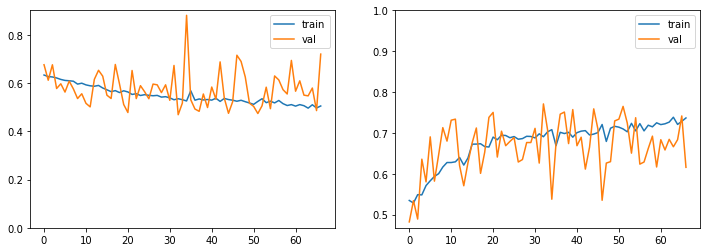

In [16]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5010 - accuracy: 0.7412 - precision: 0.7970 - recall: 0.7260 - f1: 0.7362 - specificity: 0.7662 - negative_predictive_value: 0.7144 - matthews_correlation_coefficient: 0.5089 - val_loss: 0.3911 - val_accuracy: 0.7997 - val_precision: 0.8255 - val_recall: 0.7593 - val_f1: 0.7868 - val_specificity: 0.7999 - val_negative_predictive_value: 0.7276 - val_matthews_correlation_coefficient: 0.5829

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.58294, saving model to ../models/autoencoders_requirements/varied_background_2020_03_29-23_44_25.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4397 - accuracy: 0.7679 - precision: 0.8181 - recall: 0.7822 - f1: 0.7837 - specificity: 0.7655 - negative_predictive_value: 0.7522 - matthews_correlation_coefficient: 0.5579 - val_loss: 0.3786 - val_accuracy: 0.8101 - val_pre


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.66967
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3459 - accuracy: 0.8299 - precision: 0.8574 - recall: 0.8292 - f1: 0.8362 - specificity: 0.8321 - negative_predictive_value: 0.7950 - matthews_correlation_coefficient: 0.6634 - val_loss: 0.3355 - val_accuracy: 0.8291 - val_precision: 0.8759 - val_recall: 0.7577 - val_f1: 0.8082 - val_specificity: 0.8640 - val_negative_predictive_value: 0.7428 - val_matthews_correlation_coefficient: 0.6467

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.66967
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3566 - accuracy: 0.8167 - precision: 0.8608 - recall: 0.8105 - f1: 0.8264 - specificity: 0.8368 - negative_predictive_value: 0.7811 - matthews_correlation_coefficient: 0.6440 - val_loss: 0.3462 - val_accuracy: 0.8265 - val_precision: 0.8984 - val_recall: 0.7304 - val_f1: 0.8005 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3226 - accuracy: 0.8406 - precision: 0.8769 - recall: 0.8357 - f1: 0.8506 - specificity: 0.8545 - negative_predictive_value: 0.8053 - matthews_correlation_coefficient: 0.6858 - val_loss: 0.3001 - val_accuracy: 0.8465 - val_precision: 0.8751 - val_recall: 0.7862 - val_f1: 0.8253 - val_specificity: 0.8650 - val_negative_predictive_value: 0.7679 - val_matthews_correlation_coefficient: 0.6738

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.69890
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3258 - accuracy: 0.8406 - precision: 0.8704 - recall: 0.8346 - f1: 0.8461 - specificity: 0.8479 - negative_predictive_value: 0.8046 - matthews_correlation_coefficient: 0.6799 - val_loss: 0.2897 - val_accuracy: 0.8543 - val_precision: 0.8769 - val_recall: 0.8037 - val_f1: 0.8362 - val_specificity: 0.8636 - val_negative_predictive_value: 0.7784 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.71276
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3076 - accuracy: 0.8477 - precision: 0.8813 - recall: 0.8502 - f1: 0.8605 - specificity: 0.8554 - negative_predictive_value: 0.8139 - matthews_correlation_coefficient: 0.6997 - val_loss: 0.2902 - val_accuracy: 0.8569 - val_precision: 0.8571 - val_recall: 0.8374 - val_f1: 0.8447 - val_specificity: 0.8279 - val_negative_predictive_value: 0.8005 - val_matthews_correlation_coefficient: 0.6884

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.71276
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3099 - accuracy: 0.8445 - precision: 0.8686 - recall: 0.8421 - f1: 0.8498 - specificity: 0.8428 - negative_predictive_value: 0.8103 - matthews_correlation_coefficient: 0.6816 - val_loss: 0.2856 - val_accuracy: 0.8656 - val_precision: 0.8749 - val_recall: 0.8340 - val_f1: 0.8502 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2967 - accuracy: 0.8508 - precision: 0.8845 - recall: 0.8510 - f1: 0.8628 - specificity: 0.8583 - negative_predictive_value: 0.8181 - matthews_correlation_coefficient: 0.7056 - val_loss: 0.3144 - val_accuracy: 0.8448 - val_precision: 0.8501 - val_recall: 0.8827 - val_f1: 0.8641 - val_specificity: 0.7712 - val_negative_predictive_value: 0.8079 - val_matthews_correlation_coefficient: 0.6558

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.73509
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2943 - accuracy: 0.8566 - precision: 0.8871 - recall: 0.8596 - f1: 0.8677 - specificity: 0.8598 - negative_predictive_value: 0.8308 - matthews_correlation_coefficient: 0.7183 - val_loss: 0.3006 - val_accuracy: 0.8560 - val_precision: 0.8434 - val_recall: 0.9146 - val_f1: 0.8754 - val_specificity: 0.7578 - val_negative_predictive_value: 0.8484 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.73834
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2813 - accuracy: 0.8625 - precision: 0.8904 - recall: 0.8633 - f1: 0.8721 - specificity: 0.8649 - negative_predictive_value: 0.8255 - matthews_correlation_coefficient: 0.7217 - val_loss: 0.2928 - val_accuracy: 0.8560 - val_precision: 0.8390 - val_recall: 0.9257 - val_f1: 0.8776 - val_specificity: 0.7452 - val_negative_predictive_value: 0.8570 - val_matthews_correlation_coefficient: 0.6831

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.73834
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2810 - accuracy: 0.8653 - precision: 0.8873 - recall: 0.8608 - f1: 0.8704 - specificity: 0.8668 - negative_predictive_value: 0.8333 - matthews_correlation_coefficient: 0.7256 - val_loss: 0.2770 - val_accuracy: 0.8768 - val_precision: 0.9017 - val_recall: 0.8248 - val_f1: 0.8590 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2734 - accuracy: 0.8709 - precision: 0.8965 - recall: 0.8758 - f1: 0.8813 - specificity: 0.8772 - negative_predictive_value: 0.8470 - matthews_correlation_coefficient: 0.7478 - val_loss: 0.2527 - val_accuracy: 0.8760 - val_precision: 0.8912 - val_recall: 0.8908 - val_f1: 0.8887 - val_specificity: 0.8365 - val_negative_predictive_value: 0.8309 - val_matthews_correlation_coefficient: 0.7246

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.74247
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2677 - accuracy: 0.8701 - precision: 0.8899 - recall: 0.8648 - f1: 0.8735 - specificity: 0.8728 - negative_predictive_value: 0.8414 - matthews_correlation_coefficient: 0.7359 - val_loss: 0.2785 - val_accuracy: 0.8673 - val_precision: 0.8865 - val_recall: 0.8823 - val_f1: 0.8821 - val_specificity: 0.8270 - val_negative_predictive_value: 0.8175 - val_matthews_correlation_coefficie

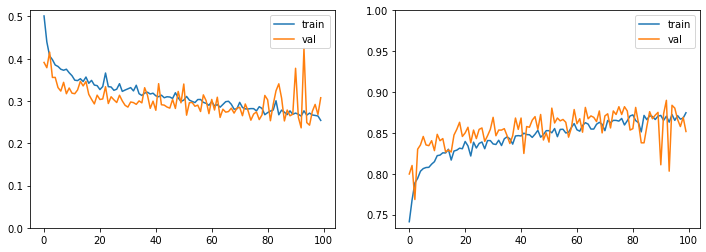

In [17]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5922 - accuracy: 0.7015 - precision: 0.8983 - recall: 0.6843 - f1: 0.7727 - specificity: 0.7626 - negative_predictive_value: 0.4370 - matthews_correlation_coefficient: 0.3848 - val_loss: 0.5399 - val_accuracy: 0.7025 - val_precision: 0.8759 - val_recall: 0.6659 - val_f1: 0.7536 - val_specificity: 0.7596 - val_negative_predictive_value: 0.4504 - val_matthews_correlation_coefficient: 0.3704

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.37043, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_29-23_59_19.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5730 - accuracy: 0.7076 - precision: 0.9078 - recall: 0.6802 - f1: 0.7743 - specificity: 0.7819 - negative_predictive_value: 0.4431 - matthews_correlation_coefficient: 0.4020 - val_loss: 0.5616 - val_accuracy: 0.7016 - val_precis


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.38892
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5593 - accuracy: 0.7030 - precision: 0.9111 - recall: 0.6692 - f1: 0.7679 - specificity: 0.8051 - negative_predictive_value: 0.4430 - matthews_correlation_coefficient: 0.4091 - val_loss: 0.6125 - val_accuracy: 0.6722 - val_precision: 0.8933 - val_recall: 0.6071 - val_f1: 0.7205 - val_specificity: 0.8192 - val_negative_predictive_value: 0.4246 - val_matthews_correlation_coefficient: 0.3658

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.38892
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5598 - accuracy: 0.7056 - precision: 0.9137 - recall: 0.6764 - f1: 0.7736 - specificity: 0.7946 - negative_predictive_value: 0.4384 - matthews_correlation_coefficient: 0.4052 - val_loss: 0.5556 - val_accuracy: 0.6982 - val_precision: 0.8863 - val_recall: 0.6501 - val_f1: 0.7471 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5554 - accuracy: 0.7059 - precision: 0.9168 - recall: 0.6732 - f1: 0.7727 - specificity: 0.8224 - negative_predictive_value: 0.4476 - matthews_correlation_coefficient: 0.4224 - val_loss: 0.5324 - val_accuracy: 0.7147 - val_precision: 0.8794 - val_recall: 0.6818 - val_f1: 0.7651 - val_specificity: 0.7553 - val_negative_predictive_value: 0.4604 - val_matthews_correlation_coefficient: 0.3832

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.39354
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5548 - accuracy: 0.7098 - precision: 0.9156 - recall: 0.6798 - f1: 0.7767 - specificity: 0.8071 - negative_predictive_value: 0.4462 - matthews_correlation_coefficient: 0.4175 - val_loss: 0.5307 - val_accuracy: 0.7121 - val_precision: 0.8781 - val_recall: 0.6777 - val_f1: 0.7617 - val_specificity: 0.7673 - val_negative_predictive_value: 0.4607 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.39731
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5510 - accuracy: 0.7117 - precision: 0.9188 - recall: 0.6753 - f1: 0.7757 - specificity: 0.8089 - negative_predictive_value: 0.4447 - matthews_correlation_coefficient: 0.4187 - val_loss: 0.5362 - val_accuracy: 0.7095 - val_precision: 0.8814 - val_recall: 0.6693 - val_f1: 0.7578 - val_specificity: 0.7787 - val_negative_predictive_value: 0.4573 - val_matthews_correlation_coefficient: 0.3872

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39731
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5472 - accuracy: 0.7154 - precision: 0.9106 - recall: 0.6800 - f1: 0.7753 - specificity: 0.8111 - negative_predictive_value: 0.4514 - matthews_correlation_coefficient: 0.4191 - val_loss: 0.5689 - val_accuracy: 0.6947 - val_precision: 0.8880 - val_recall: 0.6433 - val_f1: 0.7436 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.40165
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5402 - accuracy: 0.7210 - precision: 0.9211 - recall: 0.6930 - f1: 0.7873 - specificity: 0.8038 - negative_predictive_value: 0.4586 - matthews_correlation_coefficient: 0.4329 - val_loss: 0.5492 - val_accuracy: 0.7181 - val_precision: 0.8784 - val_recall: 0.6843 - val_f1: 0.7660 - val_specificity: 0.7673 - val_negative_predictive_value: 0.4678 - val_matthews_correlation_coefficient: 0.3930

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.40165
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5384 - accuracy: 0.7234 - precision: 0.9224 - recall: 0.6942 - f1: 0.7876 - specificity: 0.8074 - negative_predictive_value: 0.4605 - matthews_correlation_coefficient: 0.4363 - val_loss: 0.5772 - val_accuracy: 0.6817 - val_precision: 0.8870 - val_recall: 0.6259 - val_f1: 0.7301 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.40165
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5372 - accuracy: 0.7197 - precision: 0.9191 - recall: 0.6921 - f1: 0.7862 - specificity: 0.8068 - negative_predictive_value: 0.4562 - matthews_correlation_coefficient: 0.4309 - val_loss: 0.5249 - val_accuracy: 0.7155 - val_precision: 0.8812 - val_recall: 0.6795 - val_f1: 0.7636 - val_specificity: 0.7758 - val_negative_predictive_value: 0.4661 - val_matthews_correlation_coefficient: 0.3951

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.40165
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5321 - accuracy: 0.7249 - precision: 0.9222 - recall: 0.6982 - f1: 0.7904 - specificity: 0.8148 - negative_predictive_value: 0.4712 - matthews_correlation_coefficient: 0.4470 - val_loss: 0.5824 - val_accuracy: 0.6860 - val_precision: 0.8916 - val_recall: 0.6284 - val_f1: 0.7344 - val_spe

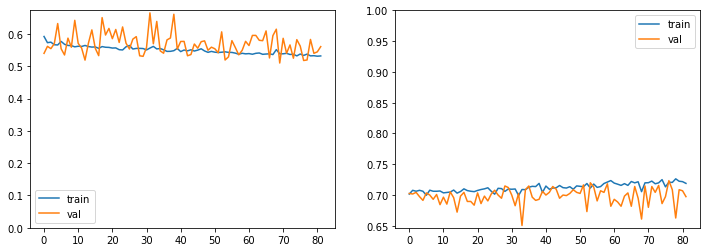

In [18]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6170 - accuracy: 0.6599 - precision: 0.6958 - recall: 0.6571 - f1: 0.6425 - specificity: 0.6665 - negative_predictive_value: 0.6685 - matthews_correlation_coefficient: 0.3482 - val_loss: 0.5759 - val_accuracy: 0.6748 - val_precision: 0.7337 - val_recall: 0.6178 - val_f1: 0.6645 - val_specificity: 0.7268 - val_negative_predictive_value: 0.6144 - val_matthews_correlation_coefficient: 0.3461

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.34609, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_30-00_11_34.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5678 - accuracy: 0.7121 - precision: 0.7088 - recall: 0.7935 - f1: 0.7363 - specificity: 0.6345 - negative_predictive_value: 0.7484 - matthews_correlation_coefficient: 0.4410 - val_loss: 0.5453 - val_accuracy: 0.7155 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4639 - accuracy: 0.7709 - precision: 0.7635 - recall: 0.8235 - f1: 0.7836 - specificity: 0.7167 - negative_predictive_value: 0.7847 - matthews_correlation_coefficient: 0.5454 - val_loss: 0.4998 - val_accuracy: 0.7294 - val_precision: 0.8275 - val_recall: 0.6295 - val_f1: 0.7063 - val_specificity: 0.8292 - val_negative_predictive_value: 0.6495 - val_matthews_correlation_coefficient: 0.4668

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.52047
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4719 - accuracy: 0.7631 - precision: 0.7726 - recall: 0.7776 - f1: 0.7671 - specificity: 0.7448 - negative_predictive_value: 0.7577 - matthews_correlation_coefficient: 0.5278 - val_loss: 0.4559 - val_accuracy: 0.7771 - val_precision: 0.7727 - val_recall: 0.8229 - val_f1: 0.7921 - val_specificity: 0.7121 - val_negative_predictive_value: 0.7694 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4484 - accuracy: 0.7818 - precision: 0.7887 - recall: 0.7937 - f1: 0.7824 - specificity: 0.7614 - negative_predictive_value: 0.7815 - matthews_correlation_coefficient: 0.5639 - val_loss: 0.4432 - val_accuracy: 0.7823 - val_precision: 0.7924 - val_recall: 0.8019 - val_f1: 0.7924 - val_specificity: 0.7449 - val_negative_predictive_value: 0.7543 - val_matthews_correlation_coefficient: 0.5465

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.55855
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4376 - accuracy: 0.7863 - precision: 0.7845 - recall: 0.8073 - f1: 0.7896 - specificity: 0.7527 - negative_predictive_value: 0.7848 - matthews_correlation_coefficient: 0.5643 - val_loss: 0.4564 - val_accuracy: 0.7710 - val_precision: 0.8343 - val_recall: 0.7140 - val_f1: 0.7622 - val_specificity: 0.8221 - val_negative_predictive_value: 0.7042 - val_matthews_correlation_coefficie


Epoch 00042: val_matthews_correlation_coefficient improved from 0.57225 to 0.57291, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_30-00_11_34.h5
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4210 - accuracy: 0.7959 - precision: 0.7961 - recall: 0.8379 - f1: 0.8089 - specificity: 0.7554 - negative_predictive_value: 0.8098 - matthews_correlation_coefficient: 0.5990 - val_loss: 0.4421 - val_accuracy: 0.7771 - val_precision: 0.7815 - val_recall: 0.8049 - val_f1: 0.7889 - val_specificity: 0.7309 - val_negative_predictive_value: 0.7572 - val_matthews_correlation_coefficient: 0.5369

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.57291
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4136 - accuracy: 0.8000 - precision: 0.7998 - recall: 0.8188 - f1: 0.8028 - specificity: 0.7711 - negative_predictive_value: 0.7946 - matthews_correlation_coefficient: 0.5916 - val_lo

4610/4610 [==============================] - 10s 2ms/step - loss: 0.4110 - accuracy: 0.8080 - precision: 0.8171 - recall: 0.8138 - f1: 0.8064 - specificity: 0.7949 - negative_predictive_value: 0.8012 - matthews_correlation_coefficient: 0.6198 - val_loss: 0.4556 - val_accuracy: 0.7762 - val_precision: 0.8567 - val_recall: 0.6962 - val_f1: 0.7609 - val_specificity: 0.8472 - val_negative_predictive_value: 0.6998 - val_matthews_correlation_coefficient: 0.5492

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.59220
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4130 - accuracy: 0.8015 - precision: 0.8097 - recall: 0.8049 - f1: 0.7985 - specificity: 0.7947 - negative_predictive_value: 0.7970 - matthews_correlation_coefficient: 0.6044 - val_loss: 0.4447 - val_accuracy: 0.7875 - val_precision: 0.8222 - val_recall: 0.7656 - val_f1: 0.7891 - val_specificity: 0.7953 - val_negative_predictive_value: 0.7332 - val_matthews_correlation_coeffici


Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.59681
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3935 - accuracy: 0.8163 - precision: 0.8306 - recall: 0.8287 - f1: 0.8232 - specificity: 0.8091 - negative_predictive_value: 0.8104 - matthews_correlation_coefficient: 0.6390 - val_loss: 0.4207 - val_accuracy: 0.7953 - val_precision: 0.8473 - val_recall: 0.7524 - val_f1: 0.7927 - val_specificity: 0.8239 - val_negative_predictive_value: 0.7295 - val_matthews_correlation_coefficient: 0.5762

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.59681
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3957 - accuracy: 0.8085 - precision: 0.8110 - recall: 0.8296 - f1: 0.8136 - specificity: 0.7828 - negative_predictive_value: 0.8039 - matthews_correlation_coefficient: 0.6133 - val_loss: 0.4216 - val_accuracy: 0.7979 - val_precision: 0.7830 - val_recall: 0.8658 - val_f1: 0.8179 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3800 - accuracy: 0.8284 - precision: 0.8377 - recall: 0.8484 - f1: 0.8358 - specificity: 0.8186 - negative_predictive_value: 0.8304 - matthews_correlation_coefficient: 0.6673 - val_loss: 0.4589 - val_accuracy: 0.8057 - val_precision: 0.7928 - val_recall: 0.8662 - val_f1: 0.8245 - val_specificity: 0.7198 - val_negative_predictive_value: 0.8040 - val_matthews_correlation_coefficient: 0.5911

Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.60656
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3886 - accuracy: 0.8145 - precision: 0.8212 - recall: 0.8216 - f1: 0.8140 - specificity: 0.8037 - negative_predictive_value: 0.8102 - matthews_correlation_coefficient: 0.6297 - val_loss: 0.4141 - val_accuracy: 0.8031 - val_precision: 0.8178 - val_recall: 0.8115 - val_f1: 0.8109 - val_specificity: 0.7766 - val_negative_predictive_value: 0.7684 - val_matthews_correlation_coefficie


Epoch 00100: val_matthews_correlation_coefficient did not improve from 0.60720

   Final Accuracy:  80.31%
  Final Precision:  79.20%
     Final Recall:  84.82%
  Final F-measure:  81.91%
Final Specificity:  75.32%
        Final NPV:  81.75%
        Final MCC:  60.54%
[[412 135]
 [ 92 514]]
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       547
           1       0.79      0.85      0.82       606

    accuracy                           0.80      1153
   macro avg       0.80      0.80      0.80      1153
weighted avg       0.80      0.80      0.80      1153



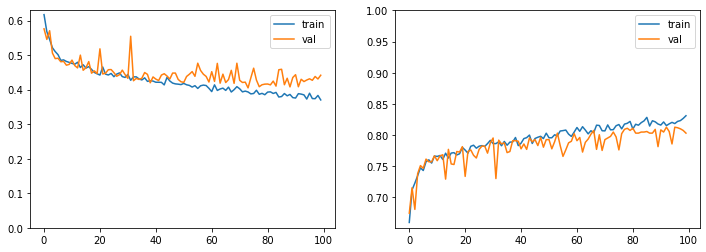

In [19]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6493 - accuracy: 0.5228 - precision: 0.8932 - recall: 0.4537 - f1: 0.5898 - specificity: 0.7909 - negative_predictive_value: 0.2825 - matthews_correlation_coefficient: 0.2063 - val_loss: 0.6377 - val_accuracy: 0.5525 - val_precision: 0.9425 - val_recall: 0.4777 - val_f1: 0.6233 - val_specificity: 0.8526 - val_negative_predictive_value: 0.3022 - val_matthews_correlation_coefficient: 0.2825

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28249, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_30-00_26_31.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6297 - accuracy: 0.5443 - precision: 0.9140 - recall: 0.4694 - f1: 0.6073 - specificity: 0.8121 - negative_predictive_value: 0.2945 - matthews_correlation_coefficient: 0.2417 - val_loss: 0.6451 - val_accuracy: 0.5308 - val_precision: 0


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.36651
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5746 - accuracy: 0.6562 - precision: 0.9073 - recall: 0.6213 - f1: 0.7277 - specificity: 0.7675 - negative_predictive_value: 0.3654 - matthews_correlation_coefficient: 0.3302 - val_loss: 0.5997 - val_accuracy: 0.6245 - val_precision: 0.9246 - val_recall: 0.5847 - val_f1: 0.7101 - val_specificity: 0.7867 - val_negative_predictive_value: 0.3284 - val_matthews_correlation_coefficient: 0.3051

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.36651
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5721 - accuracy: 0.6733 - precision: 0.9002 - recall: 0.6603 - f1: 0.7517 - specificity: 0.7250 - negative_predictive_value: 0.3792 - matthews_correlation_coefficient: 0.3252 - val_loss: 0.5757 - val_accuracy: 0.6418 - val_precision: 0.9204 - val_recall: 0.6097 - val_f1: 0.7281 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.37288
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5340 - accuracy: 0.7004 - precision: 0.9125 - recall: 0.6755 - f1: 0.7703 - specificity: 0.7825 - negative_predictive_value: 0.4079 - matthews_correlation_coefficient: 0.3809 - val_loss: 0.5934 - val_accuracy: 0.6592 - val_precision: 0.9425 - val_recall: 0.6158 - val_f1: 0.7393 - val_specificity: 0.8325 - val_negative_predictive_value: 0.3609 - val_matthews_correlation_coefficient: 0.3673

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.37288
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5541 - accuracy: 0.6831 - precision: 0.9100 - recall: 0.6575 - f1: 0.7538 - specificity: 0.7619 - negative_predictive_value: 0.3961 - matthews_correlation_coefficient: 0.3614 - val_loss: 0.5174 - val_accuracy: 0.7355 - val_precision: 0.9122 - val_recall: 0.7418 - val_f1: 0.8150 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5223 - accuracy: 0.7093 - precision: 0.9184 - recall: 0.6946 - f1: 0.7855 - specificity: 0.7765 - negative_predictive_value: 0.4181 - matthews_correlation_coefficient: 0.3954 - val_loss: 0.5555 - val_accuracy: 0.7095 - val_precision: 0.9242 - val_recall: 0.6959 - val_f1: 0.7893 - val_specificity: 0.7609 - val_negative_predictive_value: 0.4001 - val_matthews_correlation_coefficient: 0.3836

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39411
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5243 - accuracy: 0.7104 - precision: 0.9159 - recall: 0.7023 - f1: 0.7885 - specificity: 0.7478 - negative_predictive_value: 0.4083 - matthews_correlation_coefficient: 0.3784 - val_loss: 0.5142 - val_accuracy: 0.7199 - val_precision: 0.9044 - val_recall: 0.7289 - val_f1: 0.8045 - val_specificity: 0.6858 - val_negative_predictive_value: 0.4006 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.40615
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4989 - accuracy: 0.7289 - precision: 0.9183 - recall: 0.7117 - f1: 0.7965 - specificity: 0.7778 - negative_predictive_value: 0.4338 - matthews_correlation_coefficient: 0.4142 - val_loss: 0.5981 - val_accuracy: 0.6626 - val_precision: 0.9298 - val_recall: 0.6274 - val_f1: 0.7439 - val_specificity: 0.8070 - val_negative_predictive_value: 0.3646 - val_matthews_correlation_coefficient: 0.3562

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.40615
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5075 - accuracy: 0.7252 - precision: 0.9192 - recall: 0.7164 - f1: 0.7972 - specificity: 0.7695 - negative_predictive_value: 0.4280 - matthews_correlation_coefficient: 0.4085 - val_loss: 0.7665 - val_accuracy: 0.5429 - val_precision: 0.9443 - val_recall: 0.4611 - val_f1: 0.6116 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.40615
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5054 - accuracy: 0.7310 - precision: 0.9253 - recall: 0.7169 - f1: 0.8019 - specificity: 0.7777 - negative_predictive_value: 0.4369 - matthews_correlation_coefficient: 0.4213 - val_loss: 0.5618 - val_accuracy: 0.6843 - val_precision: 0.9274 - val_recall: 0.6603 - val_f1: 0.7676 - val_specificity: 0.7862 - val_negative_predictive_value: 0.3768 - val_matthews_correlation_coefficient: 0.3671

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.40615
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4871 - accuracy: 0.7345 - precision: 0.9278 - recall: 0.7240 - f1: 0.8072 - specificity: 0.7877 - negative_predictive_value: 0.4470 - matthews_correlation_coefficient: 0.4333 - val_loss: 0.6183 - val_accuracy: 0.6453 - val_precision: 0.9276 - val_recall: 0.6077 - val_f1: 0.7304 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4776 - accuracy: 0.7436 - precision: 0.9284 - recall: 0.7325 - f1: 0.8131 - specificity: 0.7880 - negative_predictive_value: 0.4582 - matthews_correlation_coefficient: 0.4430 - val_loss: 0.7502 - val_accuracy: 0.5837 - val_precision: 0.9317 - val_recall: 0.5229 - val_f1: 0.6636 - val_specificity: 0.8306 - val_negative_predictive_value: 0.3155 - val_matthews_correlation_coefficient: 0.2942

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.41839
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4849 - accuracy: 0.7421 - precision: 0.9187 - recall: 0.7274 - f1: 0.8050 - specificity: 0.7666 - negative_predictive_value: 0.4493 - matthews_correlation_coefficient: 0.4223 - val_loss: 0.5580 - val_accuracy: 0.6947 - val_precision: 0.9279 - val_recall: 0.6757 - val_f1: 0.7776 - val_specificity: 0.7776 - val_negative_predictive_value: 0.3860 - val_matthews_correlation_coefficie

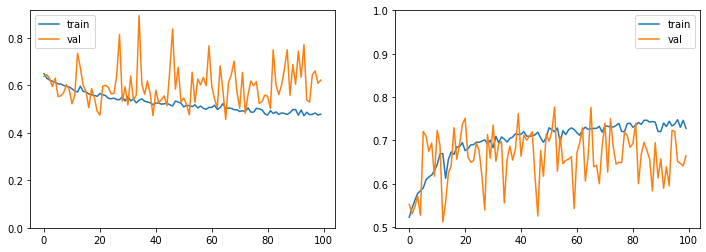

In [20]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4574 - accuracy: 0.7705 - precision: 0.8624 - recall: 0.7578 - f1: 0.7986 - specificity: 0.7934 - negative_predictive_value: 0.6587 - matthews_correlation_coefficient: 0.5420 - val_loss: 0.4521 - val_accuracy: 0.7546 - val_precision: 0.8807 - val_recall: 0.6586 - val_f1: 0.7476 - val_specificity: 0.8767 - val_negative_predictive_value: 0.6241 - val_matthews_correlation_coefficient: 0.5186

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.51861, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_30-00_41_26.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4149 - accuracy: 0.7852 - precision: 0.9057 - recall: 0.7463 - f1: 0.8116 - specificity: 0.8670 - negative_predictive_value: 0.6659 - matthews_correlation_coefficient: 0.5908 - val_loss: 0.4170 - val_accuracy: 0.7780 - val_p


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.64550
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3456 - accuracy: 0.8332 - precision: 0.9132 - recall: 0.8179 - f1: 0.8587 - specificity: 0.8698 - negative_predictive_value: 0.7385 - matthews_correlation_coefficient: 0.6686 - val_loss: 0.3704 - val_accuracy: 0.8205 - val_precision: 0.9202 - val_recall: 0.7386 - val_f1: 0.8141 - val_specificity: 0.9210 - val_negative_predictive_value: 0.7000 - val_matthews_correlation_coefficient: 0.6386

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.64550
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3486 - accuracy: 0.8430 - precision: 0.9172 - recall: 0.8289 - f1: 0.8666 - specificity: 0.8703 - negative_predictive_value: 0.7454 - matthews_correlation_coefficient: 0.6791 - val_loss: 0.3435 - val_accuracy: 0.8517 - val_precision: 0.8629 - val_recall: 0.8509 - val_f1: 0.8540 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3143 - accuracy: 0.8631 - precision: 0.9266 - recall: 0.8554 - f1: 0.8856 - specificity: 0.8798 - negative_predictive_value: 0.7744 - matthews_correlation_coefficient: 0.7172 - val_loss: 0.3406 - val_accuracy: 0.8404 - val_precision: 0.8063 - val_recall: 0.9125 - val_f1: 0.8544 - val_specificity: 0.6787 - val_negative_predictive_value: 0.8692 - val_matthews_correlation_coefficient: 0.6309

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.71599
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3098 - accuracy: 0.8629 - precision: 0.9233 - recall: 0.8548 - f1: 0.8836 - specificity: 0.8714 - negative_predictive_value: 0.7791 - matthews_correlation_coefficient: 0.7149 - val_loss: 0.3314 - val_accuracy: 0.8560 - val_precision: 0.8711 - val_recall: 0.8470 - val_f1: 0.8561 - val_specificity: 0.8248 - val_negative_predictive_value: 0.8020 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.72264
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2941 - accuracy: 0.8707 - precision: 0.9255 - recall: 0.8558 - f1: 0.8858 - specificity: 0.8875 - negative_predictive_value: 0.7825 - matthews_correlation_coefficient: 0.7316 - val_loss: 0.3364 - val_accuracy: 0.8387 - val_precision: 0.9233 - val_recall: 0.7645 - val_f1: 0.8327 - val_specificity: 0.9283 - val_negative_predictive_value: 0.7268 - val_matthews_correlation_coefficient: 0.6704

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.72264
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3169 - accuracy: 0.8603 - precision: 0.9300 - recall: 0.8453 - f1: 0.8813 - specificity: 0.8814 - negative_predictive_value: 0.7673 - matthews_correlation_coefficient: 0.7108 - val_loss: 0.3021 - val_accuracy: 0.8734 - val_precision: 0.8526 - val_recall: 0.9034 - val_f1: 0.8757 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2804 - accuracy: 0.8837 - precision: 0.9260 - recall: 0.8871 - f1: 0.9025 - specificity: 0.8774 - negative_predictive_value: 0.8128 - matthews_correlation_coefficient: 0.7526 - val_loss: 0.3413 - val_accuracy: 0.8560 - val_precision: 0.9162 - val_recall: 0.7980 - val_f1: 0.8503 - val_specificity: 0.9124 - val_negative_predictive_value: 0.7565 - val_matthews_correlation_coefficient: 0.6908

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.74491
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2890 - accuracy: 0.8740 - precision: 0.9297 - recall: 0.8683 - f1: 0.8950 - specificity: 0.8889 - negative_predictive_value: 0.7988 - matthews_correlation_coefficient: 0.7421 - val_loss: 0.2992 - val_accuracy: 0.8768 - val_precision: 0.9085 - val_recall: 0.8392 - val_f1: 0.8707 - val_specificity: 0.8969 - val_negative_predictive_value: 0.8019 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2620 - accuracy: 0.8915 - precision: 0.9329 - recall: 0.8939 - f1: 0.9107 - specificity: 0.8851 - negative_predictive_value: 0.8227 - matthews_correlation_coefficient: 0.7665 - val_loss: 0.2868 - val_accuracy: 0.8864 - val_precision: 0.8910 - val_recall: 0.8777 - val_f1: 0.8824 - val_specificity: 0.8561 - val_negative_predictive_value: 0.8426 - val_matthews_correlation_coefficient: 0.7331

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.74491
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2645 - accuracy: 0.8896 - precision: 0.9259 - recall: 0.8955 - f1: 0.9065 - specificity: 0.8837 - negative_predictive_value: 0.8240 - matthews_correlation_coefficient: 0.7652 - val_loss: 0.3116 - val_accuracy: 0.8656 - val_precision: 0.9207 - val_recall: 0.8090 - val_f1: 0.8586 - val_specificity: 0.9197 - val_negative_predictive_value: 0.7704 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.74491
Epoch 00087: early stopping

   Final Accuracy:  88.73%
  Final Precision:  93.45%
     Final Recall:  88.31%
  Final F-measure:  90.81%
Final Specificity:  89.44%
        Final NPV:  81.76%
        Final MCC:  76.47%
[[381  45]
 [ 85 642]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       426
           1       0.93      0.88      0.91       727

    accuracy                           0.89      1153
   macro avg       0.88      0.89      0.88      1153
weighted avg       0.89      0.89      0.89      1153



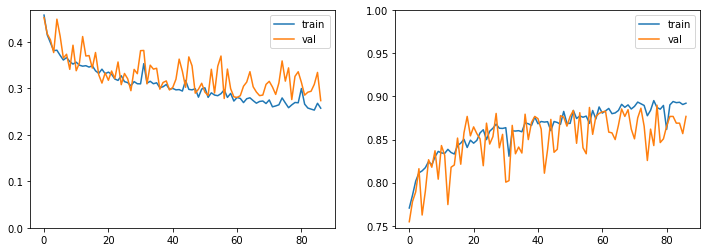

In [21]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5909 - accuracy: 0.6727 - precision: 0.7721 - recall: 0.6780 - f1: 0.7083 - specificity: 0.6671 - negative_predictive_value: 0.5569 - matthews_correlation_coefficient: 0.3402 - val_loss: 0.5787 - val_accuracy: 0.6886 - val_precision: 0.7891 - val_recall: 0.6324 - val_f1: 0.6973 - val_specificity: 0.7631 - val_negative_predictive_value: 0.5774 - val_matthews_correlation_coefficient: 0.3796

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.37960, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_30-00_54_33.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5501 - accuracy: 0.7102 - precision: 0.7987 - recall: 0.7221 - f1: 0.7508 - specificity: 0.6989 - negative_predictive_value: 0.6002 - matthews_correlation_coefficient: 0.4107 - val_loss: 0.5972 - val_accuracy: 0.6826 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4774 - accuracy: 0.7770 - precision: 0.8398 - recall: 0.7842 - f1: 0.8049 - specificity: 0.7591 - negative_predictive_value: 0.6880 - matthews_correlation_coefficient: 0.5414 - val_loss: 0.4763 - val_accuracy: 0.7910 - val_precision: 0.8181 - val_recall: 0.8003 - val_f1: 0.8059 - val_specificity: 0.7299 - val_negative_predictive_value: 0.6953 - val_matthews_correlation_coefficient: 0.5476

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.57361
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4858 - accuracy: 0.7727 - precision: 0.8429 - recall: 0.7943 - f1: 0.8091 - specificity: 0.7551 - negative_predictive_value: 0.6978 - matthews_correlation_coefficient: 0.5440 - val_loss: 0.4904 - val_accuracy: 0.7927 - val_precision: 0.7771 - val_recall: 0.8707 - val_f1: 0.8182 - val_specificity: 0.6126 - val_negative_predictive_value: 0.7526 - val_matthews_correlation_coefficie


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.59190
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4456 - accuracy: 0.8033 - precision: 0.8679 - recall: 0.8160 - f1: 0.8359 - specificity: 0.7815 - negative_predictive_value: 0.7200 - matthews_correlation_coefficient: 0.5917 - val_loss: 0.4589 - val_accuracy: 0.7944 - val_precision: 0.7649 - val_recall: 0.8972 - val_f1: 0.8231 - val_specificity: 0.5751 - val_negative_predictive_value: 0.7886 - val_matthews_correlation_coefficient: 0.5369

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.59190
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4513 - accuracy: 0.7963 - precision: 0.8594 - recall: 0.8016 - f1: 0.8233 - specificity: 0.7813 - negative_predictive_value: 0.7131 - matthews_correlation_coefficient: 0.5767 - val_loss: 0.4494 - val_accuracy: 0.8205 - val_precision: 0.8108 - val_recall: 0.8664 - val_f1: 0.8356 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4300 - accuracy: 0.8033 - precision: 0.8663 - recall: 0.8161 - f1: 0.8351 - specificity: 0.7938 - negative_predictive_value: 0.7258 - matthews_correlation_coefficient: 0.6002 - val_loss: 0.4873 - val_accuracy: 0.7892 - val_precision: 0.8373 - val_recall: 0.7633 - val_f1: 0.7957 - val_specificity: 0.8053 - val_negative_predictive_value: 0.6995 - val_matthews_correlation_coefficient: 0.5513

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.61530
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4354 - accuracy: 0.8054 - precision: 0.8659 - recall: 0.8237 - f1: 0.8378 - specificity: 0.7829 - negative_predictive_value: 0.7349 - matthews_correlation_coefficient: 0.6022 - val_loss: 0.4294 - val_accuracy: 0.8222 - val_precision: 0.8160 - val_recall: 0.8618 - val_f1: 0.8356 - val_specificity: 0.7326 - val_negative_predictive_value: 0.7909 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.62605
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4121 - accuracy: 0.8154 - precision: 0.8705 - recall: 0.8221 - f1: 0.8407 - specificity: 0.7961 - negative_predictive_value: 0.7313 - matthews_correlation_coefficient: 0.6160 - val_loss: 0.4594 - val_accuracy: 0.8049 - val_precision: 0.7799 - val_recall: 0.8857 - val_f1: 0.8275 - val_specificity: 0.6144 - val_negative_predictive_value: 0.7837 - val_matthews_correlation_coefficient: 0.5571

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.62605
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4158 - accuracy: 0.8197 - precision: 0.8706 - recall: 0.8416 - f1: 0.8514 - specificity: 0.7878 - negative_predictive_value: 0.7448 - matthews_correlation_coefficient: 0.6215 - val_loss: 0.4194 - val_accuracy: 0.8222 - val_precision: 0.8141 - val_recall: 0.8626 - val_f1: 0.8348 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.62605
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3961 - accuracy: 0.8306 - precision: 0.8838 - recall: 0.8428 - f1: 0.8590 - specificity: 0.8098 - negative_predictive_value: 0.7528 - matthews_correlation_coefficient: 0.6438 - val_loss: 0.4364 - val_accuracy: 0.8092 - val_precision: 0.7801 - val_recall: 0.8947 - val_f1: 0.8314 - val_specificity: 0.6187 - val_negative_predictive_value: 0.8005 - val_matthews_correlation_coefficient: 0.5724

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.62605
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4044 - accuracy: 0.8297 - precision: 0.8798 - recall: 0.8432 - f1: 0.8563 - specificity: 0.8079 - negative_predictive_value: 0.7598 - matthews_correlation_coefficient: 0.6462 - val_loss: 0.4344 - val_accuracy: 0.8361 - val_precision: 0.8353 - val_recall: 0.8578 - val_f1: 0.8439 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.63105
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3961 - accuracy: 0.8280 - precision: 0.8783 - recall: 0.8372 - f1: 0.8526 - specificity: 0.8124 - negative_predictive_value: 0.7475 - matthews_correlation_coefficient: 0.6385 - val_loss: 0.4506 - val_accuracy: 0.8196 - val_precision: 0.8272 - val_recall: 0.8373 - val_f1: 0.8298 - val_specificity: 0.7648 - val_negative_predictive_value: 0.7742 - val_matthews_correlation_coefficient: 0.6012

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.63105
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3956 - accuracy: 0.8215 - precision: 0.8713 - recall: 0.8257 - f1: 0.8438 - specificity: 0.8100 - negative_predictive_value: 0.7431 - matthews_correlation_coefficient: 0.6240 - val_loss: 0.4265 - val_accuracy: 0.8317 - val_precision: 0.8472 - val_recall: 0.8359 - val_f1: 0.8389 - val_spe

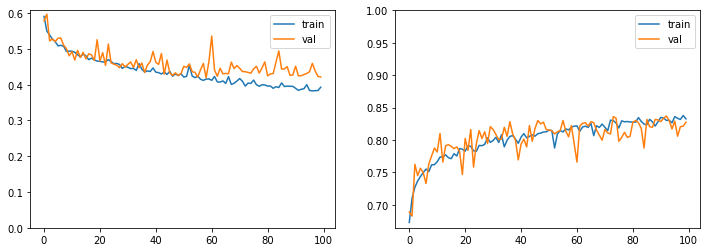

In [22]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5776 - accuracy: 0.5362 - precision: 0.9630 - recall: 0.4917 - f1: 0.6452 - specificity: 0.8576 - negative_predictive_value: 0.1822 - matthews_correlation_coefficient: 0.2254 - val_loss: 0.7165 - val_accuracy: 0.4657 - val_precision: 0.9556 - val_recall: 0.3949 - val_f1: 0.5530 - val_specificity: 0.9316 - val_negative_predictive_value: 0.1866 - val_matthews_correlation_coefficient: 0.2134

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21341, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_30-01_09_32.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5594 - accuracy: 0.5644 - precision: 0.9672 - recall: 0.5310 - f1: 0.6773 - specificity: 0.8021 - negative_predictive_value: 0.1880 - matthews_correlation_coefficient: 0.2286 - val_loss: 0.5532 - val_accuracy: 0.5256 - val_pr


Epoch 00014: val_matthews_correlation_coefficient improved from 0.31574 to 0.32630, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_30-01_09_32.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4531 - accuracy: 0.7184 - precision: 0.9659 - recall: 0.6996 - f1: 0.8051 - specificity: 0.8323 - negative_predictive_value: 0.2765 - matthews_correlation_coefficient: 0.3575 - val_loss: 0.5992 - val_accuracy: 0.6193 - val_precision: 0.9542 - val_recall: 0.5650 - val_f1: 0.7052 - val_specificity: 0.9077 - val_negative_predictive_value: 0.2354 - val_matthews_correlation_coefficient: 0.2939

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.32630
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4412 - accuracy: 0.7230 - precision: 0.9746 - recall: 0.7101 - f1: 0.8156 - specificity: 0.8325 - negative_predictive_value: 0.2776 - matthews_correlation_coefficient: 0.3617 - val_loss: 0.


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.43355
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3900 - accuracy: 0.7707 - precision: 0.9836 - recall: 0.7538 - f1: 0.8487 - specificity: 0.8725 - negative_predictive_value: 0.3243 - matthews_correlation_coefficient: 0.4319 - val_loss: 0.3865 - val_accuracy: 0.7832 - val_precision: 0.9473 - val_recall: 0.7567 - val_f1: 0.8385 - val_specificity: 0.8082 - val_negative_predictive_value: 0.3182 - val_matthews_correlation_coefficient: 0.4066

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.43355
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4014 - accuracy: 0.7657 - precision: 0.9779 - recall: 0.7569 - f1: 0.8476 - specificity: 0.8568 - negative_predictive_value: 0.3330 - matthews_correlation_coefficient: 0.4283 - val_loss: 0.4464 - val_accuracy: 0.7398 - val_precision: 0.9582 - val_recall: 0.6975 - val_f1: 0.8049 - val_spe


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.45898
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3917 - accuracy: 0.7740 - precision: 0.9801 - recall: 0.7617 - f1: 0.8490 - specificity: 0.8286 - negative_predictive_value: 0.3388 - matthews_correlation_coefficient: 0.4262 - val_loss: 0.4029 - val_accuracy: 0.7580 - val_precision: 0.9664 - val_recall: 0.7112 - val_f1: 0.8166 - val_specificity: 0.9358 - val_negative_predictive_value: 0.3258 - val_matthews_correlation_coefficient: 0.4271

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.45898
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3711 - accuracy: 0.7720 - precision: 0.9814 - recall: 0.7604 - f1: 0.8522 - specificity: 0.8684 - negative_predictive_value: 0.3247 - matthews_correlation_coefficient: 0.4286 - val_loss: 0.3138 - val_accuracy: 0.8404 - val_precision: 0.9490 - val_recall: 0.8183 - val_f1: 0.8779 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3805 - accuracy: 0.7692 - precision: 0.9765 - recall: 0.7496 - f1: 0.8405 - specificity: 0.8502 - negative_predictive_value: 0.3389 - matthews_correlation_coefficient: 0.4289 - val_loss: 0.6904 - val_accuracy: 0.6271 - val_precision: 0.9713 - val_recall: 0.5638 - val_f1: 0.7092 - val_specificity: 0.9691 - val_negative_predictive_value: 0.2442 - val_matthews_correlation_coefficient: 0.3333

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.48598
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3834 - accuracy: 0.7711 - precision: 0.9807 - recall: 0.7553 - f1: 0.8455 - specificity: 0.8507 - negative_predictive_value: 0.3412 - matthews_correlation_coefficient: 0.4309 - val_loss: 0.4416 - val_accuracy: 0.7398 - val_precision: 0.9688 - val_recall: 0.6891 - val_f1: 0.8027 - val_specificity: 0.9562 - val_negative_predictive_value: 0.3081 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3363 - accuracy: 0.8087 - precision: 0.9832 - recall: 0.8005 - f1: 0.8779 - specificity: 0.8717 - negative_predictive_value: 0.3681 - matthews_correlation_coefficient: 0.4772 - val_loss: 0.5905 - val_accuracy: 0.6791 - val_precision: 0.9713 - val_recall: 0.6208 - val_f1: 0.7540 - val_specificity: 0.9691 - val_negative_predictive_value: 0.2704 - val_matthews_correlation_coefficient: 0.3714

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.48598
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3366 - accuracy: 0.8078 - precision: 0.9824 - recall: 0.7990 - f1: 0.8760 - specificity: 0.8469 - negative_predictive_value: 0.3832 - matthews_correlation_coefficient: 0.4750 - val_loss: 0.7185 - val_accuracy: 0.6219 - val_precision: 0.9712 - val_recall: 0.5583 - val_f1: 0.7052 - val_specificity: 0.9691 - val_negative_predictive_value: 0.2426 - val_matthews_correlation_coefficie

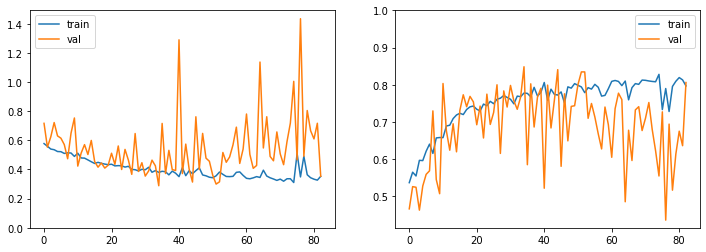

In [23]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5813 - accuracy: 0.6540 - precision: 0.9138 - recall: 0.6263 - f1: 0.7333 - specificity: 0.7690 - negative_predictive_value: 0.3573 - matthews_correlation_coefficient: 0.3256 - val_loss: 0.6362 - val_accuracy: 0.6349 - val_precision: 0.9072 - val_recall: 0.6096 - val_f1: 0.7233 - val_specificity: 0.7459 - val_negative_predictive_value: 0.3353 - val_matthews_correlation_coefficient: 0.2921

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29210, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_30-01_22_01.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5613 - accuracy: 0.6800 - precision: 0.8998 - recall: 0.6641 - f1: 0.7578 - specificity: 0.7341 - negative_predictive_value: 0.3733 - matthews_correlation_coefficient: 0.3346 - val_loss: 0.6456 - val_accuracy: 0.6288 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.33851
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5201 - accuracy: 0.6887 - precision: 0.9168 - recall: 0.6629 - f1: 0.7622 - specificity: 0.7898 - negative_predictive_value: 0.3876 - matthews_correlation_coefficient: 0.3748 - val_loss: 0.6592 - val_accuracy: 0.6080 - val_precision: 0.9420 - val_recall: 0.5525 - val_f1: 0.6876 - val_specificity: 0.8395 - val_negative_predictive_value: 0.3278 - val_matthews_correlation_coefficient: 0.3231

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.33851
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5175 - accuracy: 0.7195 - precision: 0.9309 - recall: 0.6990 - f1: 0.7929 - specificity: 0.7996 - negative_predictive_value: 0.4151 - matthews_correlation_coefficient: 0.4132 - val_loss: 0.5567 - val_accuracy: 0.7008 - val_precision: 0.9072 - val_recall: 0.7033 - val_f1: 0.7882 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4922 - accuracy: 0.7221 - precision: 0.9286 - recall: 0.7057 - f1: 0.7946 - specificity: 0.7855 - negative_predictive_value: 0.4246 - matthews_correlation_coefficient: 0.4146 - val_loss: 0.5480 - val_accuracy: 0.6713 - val_precision: 0.9351 - val_recall: 0.6406 - val_f1: 0.7557 - val_specificity: 0.8010 - val_negative_predictive_value: 0.3610 - val_matthews_correlation_coefficient: 0.3599

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.37935
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4876 - accuracy: 0.7286 - precision: 0.9236 - recall: 0.7077 - f1: 0.7951 - specificity: 0.7882 - negative_predictive_value: 0.4286 - matthews_correlation_coefficient: 0.4160 - val_loss: 0.6180 - val_accuracy: 0.6418 - val_precision: 0.9340 - val_recall: 0.6010 - val_f1: 0.7264 - val_specificity: 0.8173 - val_negative_predictive_value: 0.3426 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.39826
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4697 - accuracy: 0.7234 - precision: 0.9336 - recall: 0.7047 - f1: 0.7970 - specificity: 0.8126 - negative_predictive_value: 0.4293 - matthews_correlation_coefficient: 0.4291 - val_loss: 0.6134 - val_accuracy: 0.6565 - val_precision: 0.9391 - val_recall: 0.6180 - val_f1: 0.7396 - val_specificity: 0.8187 - val_negative_predictive_value: 0.3580 - val_matthews_correlation_coefficient: 0.3582

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39826
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4631 - accuracy: 0.7434 - precision: 0.9349 - recall: 0.7282 - f1: 0.8121 - specificity: 0.7994 - negative_predictive_value: 0.4460 - matthews_correlation_coefficient: 0.4457 - val_loss: 0.7706 - val_accuracy: 0.6158 - val_precision: 0.9390 - val_recall: 0.5643 - val_f1: 0.6988 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.39826
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4545 - accuracy: 0.7549 - precision: 0.9333 - recall: 0.7358 - f1: 0.8169 - specificity: 0.8163 - negative_predictive_value: 0.4629 - matthews_correlation_coefficient: 0.4632 - val_loss: 0.5057 - val_accuracy: 0.7155 - val_precision: 0.9215 - val_recall: 0.7115 - val_f1: 0.7995 - val_specificity: 0.7391 - val_negative_predictive_value: 0.3947 - val_matthews_correlation_coefficient: 0.3757

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.39826
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4559 - accuracy: 0.7518 - precision: 0.9343 - recall: 0.7419 - f1: 0.8200 - specificity: 0.8049 - negative_predictive_value: 0.4655 - matthews_correlation_coefficient: 0.4630 - val_loss: 0.7035 - val_accuracy: 0.6158 - val_precision: 0.9513 - val_recall: 0.5570 - val_f1: 0.6958 - val_spe

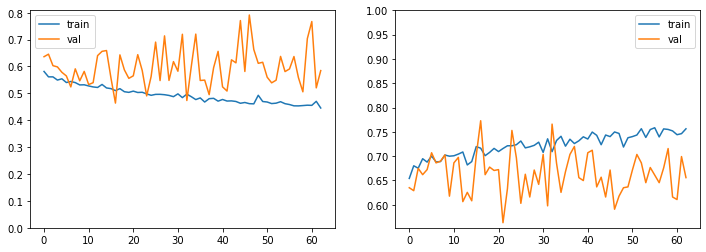

In [24]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5911 - accuracy: 0.7879 - precision: 0.9987 - recall: 0.7900 - f1: 0.8731 - specificity: 0.0621 - negative_predictive_value: 0.0067 - matthews_correlation_coefficient: 0.0169 - val_loss: 0.1556 - val_accuracy: 0.9670 - val_precision: 0.9983 - val_recall: 0.9695 - val_f1: 0.9833 - val_specificity: 0.0541 - val_negative_predictive_value: 0.0270 - val_matthews_correlation_coefficient: 0.0367

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.03673, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_30-01_31_34.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4883 - accuracy: 0.7336 - precision: 0.9989 - recall: 0.7358 - f1: 0.8349 - specificity: 0.0690 - negative_predictive_value: 0.0091 - matthews_correlation_coefficient: 0.0201 - val_loss: 0.1757 - val_accuracy: 0.9332 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1847 - accuracy: 0.8866 - precision: 1.0000 - recall: 0.8870 - f1: 0.9386 - specificity: 0.0897 - negative_predictive_value: 0.0359 - matthews_correlation_coefficient: 0.0514 - val_loss: 0.2155 - val_accuracy: 0.9020 - val_precision: 1.0000 - val_recall: 0.9043 - val_f1: 0.9488 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0414 - val_matthews_correlation_coefficient: 0.0640

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.07972
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1414 - accuracy: 0.9187 - precision: 1.0000 - recall: 0.9189 - f1: 0.9569 - specificity: 0.1034 - negative_predictive_value: 0.0365 - matthews_correlation_coefficient: 0.0571 - val_loss: 0.1910 - val_accuracy: 0.9228 - val_precision: 1.0000 - val_recall: 0.9247 - val_f1: 0.9602 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0473 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.09617
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1654 - accuracy: 0.9013 - precision: 1.0000 - recall: 0.9017 - f1: 0.9469 - specificity: 0.0966 - negative_predictive_value: 0.0336 - matthews_correlation_coefficient: 0.0542 - val_loss: 0.1913 - val_accuracy: 0.9167 - val_precision: 1.0000 - val_recall: 0.9187 - val_f1: 0.9568 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0428 - val_matthews_correlation_coefficient: 0.0655

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.09617
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1305 - accuracy: 0.9252 - precision: 1.0000 - recall: 0.9254 - f1: 0.9606 - specificity: 0.0966 - negative_predictive_value: 0.0402 - matthews_correlation_coefficient: 0.0575 - val_loss: 0.0624 - val_accuracy: 0.9696 - val_precision: 1.0000 - val_recall: 0.9704 - val_f1: 0.9847 - val_spe


Epoch 00044: val_matthews_correlation_coefficient improved from 0.09617 to 0.09988, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_30-01_31_34.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1054 - accuracy: 0.9408 - precision: 1.0000 - recall: 0.9410 - f1: 0.9689 - specificity: 0.1034 - negative_predictive_value: 0.0632 - matthews_correlation_coefficient: 0.0761 - val_loss: 0.0632 - val_accuracy: 0.9731 - val_precision: 1.0000 - val_recall: 0.9738 - val_f1: 0.9865 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0946 - val_matthews_correlation_coefficient: 0.0999

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0870 - accuracy: 0.9566 - precision: 1.0000 - recall: 0.9568 - f1: 0.9774 - specificity: 0.0966 - negative_predictive_value: 0.0592 - matthews_correlation_coefficient: 0.0721 - val_loss: 0.14


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1048 - accuracy: 0.9453 - precision: 1.0000 - recall: 0.9455 - f1: 0.9715 - specificity: 0.1034 - negative_predictive_value: 0.0474 - matthews_correlation_coefficient: 0.0674 - val_loss: 0.0980 - val_accuracy: 0.9627 - val_precision: 1.0000 - val_recall: 0.9636 - val_f1: 0.9811 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0901 - val_matthews_correlation_coefficient: 0.0962

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0549 - accuracy: 0.9672 - precision: 1.0000 - recall: 0.9674 - f1: 0.9832 - specificity: 0.1034 - negative_predictive_value: 0.0730 - matthews_correlation_coefficient: 0.0842 - val_loss: 0.0567 - val_accuracy: 0.9783 - val_precision: 1.0000 - val_recall: 0.9789 - val_f1: 0.9891 - val_spe

Restoring model weights from the end of the best epoch

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.09988
Epoch 00074: early stopping

   Final Accuracy:  98.35%
  Final Precision: 100.00%
     Final Recall:  98.35%
  Final F-measure:  99.17%
Final Specificity: 100.00%
        Final NPV:  17.39%
        Final MCC:  41.36%
[[   4    0]
 [  19 1130]]
              precision    recall  f1-score   support

           0       0.17      1.00      0.30         4
           1       1.00      0.98      0.99      1149

    accuracy                           0.98      1153
   macro avg       0.59      0.99      0.64      1153
weighted avg       1.00      0.98      0.99      1153



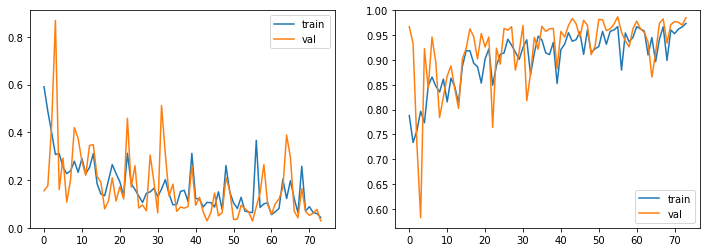

In [25]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6005 - accuracy: 0.6321 - precision: 0.8735 - recall: 0.5769 - f1: 0.6780 - specificity: 0.7603 - negative_predictive_value: 0.4090 - matthews_correlation_coefficient: 0.3177 - val_loss: 0.6352 - val_accuracy: 0.5690 - val_precision: 0.9153 - val_recall: 0.4558 - val_f1: 0.5992 - val_specificity: 0.8616 - val_negative_predictive_value: 0.3726 - val_matthews_correlation_coefficient: 0.3001

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.30013, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_30-01_42_53.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5837 - accuracy: 0.6406 - precision: 0.8902 - recall: 0.5815 - f1: 0.6935 - specificity: 0.8025 - negative_predictive_value: 0.4272 - matthews_correlation_coefficient: 0.3471 - val_loss: 0.5432 - val_accuracy: 0.6774 - val_p


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.42481
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5402 - accuracy: 0.6876 - precision: 0.9091 - recall: 0.6354 - f1: 0.7399 - specificity: 0.8274 - negative_predictive_value: 0.4713 - matthews_correlation_coefficient: 0.4187 - val_loss: 0.5790 - val_accuracy: 0.6947 - val_precision: 0.9284 - val_recall: 0.6301 - val_f1: 0.7448 - val_specificity: 0.8542 - val_negative_predictive_value: 0.4652 - val_matthews_correlation_coefficient: 0.4350

Epoch 00015: val_matthews_correlation_coefficient improved from 0.42481 to 0.43499, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_30-01_42_53.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5379 - accuracy: 0.6952 - precision: 0.9065 - recall: 0.6466 - f1: 0.7462 - specificity: 0.8191 - negative_predictive_value: 0.4781 - matthews_correlation_coefficient: 0.4226 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5012 - accuracy: 0.7234 - precision: 0.9229 - recall: 0.6758 - f1: 0.7748 - specificity: 0.8448 - negative_predictive_value: 0.5062 - matthews_correlation_coefficient: 0.4727 - val_loss: 0.5811 - val_accuracy: 0.6756 - val_precision: 0.9237 - val_recall: 0.6076 - val_f1: 0.7266 - val_specificity: 0.8485 - val_negative_predictive_value: 0.4479 - val_matthews_correlation_coefficient: 0.4103

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.43973
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5062 - accuracy: 0.7208 - precision: 0.9149 - recall: 0.6823 - f1: 0.7734 - specificity: 0.8247 - negative_predictive_value: 0.5071 - matthews_correlation_coefficient: 0.4605 - val_loss: 0.5014 - val_accuracy: 0.7225 - val_precision: 0.8594 - val_recall: 0.7411 - val_f1: 0.7927 - val_specificity: 0.6692 - val_negative_predictive_value: 0.4902 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.45952
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4877 - accuracy: 0.7306 - precision: 0.9119 - recall: 0.6861 - f1: 0.7764 - specificity: 0.8395 - negative_predictive_value: 0.5180 - matthews_correlation_coefficient: 0.4731 - val_loss: 0.5838 - val_accuracy: 0.6774 - val_precision: 0.9342 - val_recall: 0.6002 - val_f1: 0.7250 - val_specificity: 0.8743 - val_negative_predictive_value: 0.4512 - val_matthews_correlation_coefficient: 0.4262

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.45952
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4827 - accuracy: 0.7289 - precision: 0.9302 - recall: 0.6765 - f1: 0.7775 - specificity: 0.8650 - negative_predictive_value: 0.5124 - matthews_correlation_coefficient: 0.4894 - val_loss: 0.5210 - val_accuracy: 0.7095 - val_precision: 0.9017 - val_recall: 0.6746 - val_f1: 0.7667 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.46125
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4711 - accuracy: 0.7377 - precision: 0.9271 - recall: 0.6937 - f1: 0.7882 - specificity: 0.8568 - negative_predictive_value: 0.5196 - matthews_correlation_coefficient: 0.4935 - val_loss: 0.5875 - val_accuracy: 0.6791 - val_precision: 0.9295 - val_recall: 0.6074 - val_f1: 0.7276 - val_specificity: 0.8635 - val_negative_predictive_value: 0.4539 - val_matthews_correlation_coefficient: 0.4233

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.46125
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4720 - accuracy: 0.7419 - precision: 0.9296 - recall: 0.6938 - f1: 0.7894 - specificity: 0.8591 - negative_predictive_value: 0.5209 - matthews_correlation_coefficient: 0.4986 - val_loss: 0.5134 - val_accuracy: 0.7268 - val_precision: 0.9131 - val_recall: 0.6889 - val_f1: 0.7808 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46125
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4670 - accuracy: 0.7432 - precision: 0.9249 - recall: 0.7009 - f1: 0.7925 - specificity: 0.8454 - negative_predictive_value: 0.5263 - matthews_correlation_coefficient: 0.4963 - val_loss: 0.4941 - val_accuracy: 0.7285 - val_precision: 0.8941 - val_recall: 0.7111 - val_f1: 0.7892 - val_specificity: 0.7681 - val_negative_predictive_value: 0.4963 - val_matthews_correlation_coefficient: 0.4316

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.46125
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4507 - accuracy: 0.7464 - precision: 0.9230 - recall: 0.7055 - f1: 0.7935 - specificity: 0.8487 - negative_predictive_value: 0.5269 - matthews_correlation_coefficient: 0.4993 - val_loss: 0.5791 - val_accuracy: 0.6973 - val_precision: 0.9270 - val_recall: 0.6361 - val_f1: 0.7497 - val_spe

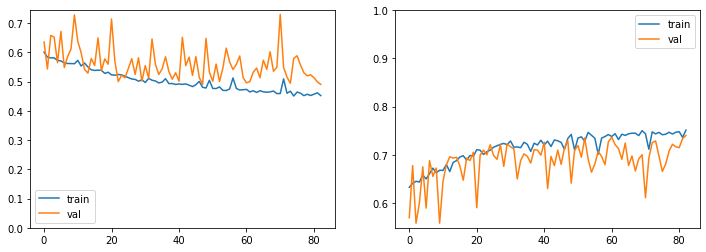

In [26]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6014 - accuracy: 0.5974 - precision: 0.9320 - recall: 0.5799 - f1: 0.6915 - specificity: 0.7074 - negative_predictive_value: 0.2159 - matthews_correlation_coefficient: 0.2079 - val_loss: 0.5518 - val_accuracy: 0.6184 - val_precision: 0.9262 - val_recall: 0.5669 - val_f1: 0.6991 - val_specificity: 0.8285 - val_negative_predictive_value: 0.2723 - val_matthews_correlation_coefficient: 0.2762

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.27618, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_30-01_55_26.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5550 - accuracy: 0.6178 - precision: 0.9460 - recall: 0.5889 - f1: 0.7159 - specificity: 0.7887 - negative_predictive_value: 0.2556 - matthews_correlation_coefficient: 0.2735 - val_loss: 0.6441 - val_accuracy: 0.5620 - val_precision: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4749 - accuracy: 0.7069 - precision: 0.9583 - recall: 0.6911 - f1: 0.7968 - specificity: 0.8070 - negative_predictive_value: 0.3184 - matthews_correlation_coefficient: 0.3676 - val_loss: 0.4565 - val_accuracy: 0.7450 - val_precision: 0.9195 - val_recall: 0.7252 - val_f1: 0.8090 - val_specificity: 0.7214 - val_negative_predictive_value: 0.3250 - val_matthews_correlation_coefficient: 0.3543

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.36739
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4688 - accuracy: 0.7197 - precision: 0.9593 - recall: 0.7069 - f1: 0.8052 - specificity: 0.8088 - negative_predictive_value: 0.3396 - matthews_correlation_coefficient: 0.3837 - val_loss: 0.5560 - val_accuracy: 0.6592 - val_precision: 0.9418 - val_recall: 0.6054 - val_f1: 0.7332 - val_specificity: 0.8912 - val_negative_predictive_value: 0.3025 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.41347
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4403 - accuracy: 0.7473 - precision: 0.9617 - recall: 0.7344 - f1: 0.8266 - specificity: 0.8326 - negative_predictive_value: 0.3586 - matthews_correlation_coefficient: 0.4211 - val_loss: 0.4885 - val_accuracy: 0.7155 - val_precision: 0.9383 - val_recall: 0.6743 - val_f1: 0.7821 - val_specificity: 0.8754 - val_negative_predictive_value: 0.3412 - val_matthews_correlation_coefficient: 0.3849

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.41347
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4906 - accuracy: 0.7108 - precision: 0.9557 - recall: 0.7014 - f1: 0.7959 - specificity: 0.7770 - negative_predictive_value: 0.3411 - matthews_correlation_coefficient: 0.3728 - val_loss: 0.4800 - val_accuracy: 0.7042 - val_precision: 0.9348 - val_recall: 0.6645 - val_f1: 0.7742 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.45879
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4053 - accuracy: 0.7768 - precision: 0.9657 - recall: 0.7669 - f1: 0.8488 - specificity: 0.8515 - negative_predictive_value: 0.3892 - matthews_correlation_coefficient: 0.4619 - val_loss: 0.4092 - val_accuracy: 0.7814 - val_precision: 0.9228 - val_recall: 0.7672 - val_f1: 0.8348 - val_specificity: 0.7720 - val_negative_predictive_value: 0.3975 - val_matthews_correlation_coefficient: 0.4069

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.45879
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4179 - accuracy: 0.7570 - precision: 0.9625 - recall: 0.7475 - f1: 0.8363 - specificity: 0.8195 - negative_predictive_value: 0.3633 - matthews_correlation_coefficient: 0.4235 - val_loss: 0.3510 - val_accuracy: 0.8179 - val_precision: 0.9026 - val_recall: 0.8318 - val_f1: 0.8638 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.45879
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3720 - accuracy: 0.7935 - precision: 0.9698 - recall: 0.7850 - f1: 0.8648 - specificity: 0.8572 - negative_predictive_value: 0.4066 - matthews_correlation_coefficient: 0.4831 - val_loss: 0.3060 - val_accuracy: 0.8708 - val_precision: 0.9029 - val_recall: 0.8970 - val_f1: 0.8985 - val_specificity: 0.5636 - val_negative_predictive_value: 0.5532 - val_matthews_correlation_coefficient: 0.4711

Epoch 00060: val_matthews_correlation_coefficient improved from 0.45879 to 0.47109, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_30-01_55_26.h5
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3788 - accuracy: 0.7939 - precision: 0.9651 - recall: 0.7870 - f1: 0.8623 - specificity: 0.8458 - negative_predictive_value: 0.4068 - matthews_correlation_coefficient: 0.4779 - val_loss: 0.3327 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3721 - accuracy: 0.8015 - precision: 0.9738 - recall: 0.7926 - f1: 0.8680 - specificity: 0.8680 - negative_predictive_value: 0.4401 - matthews_correlation_coefficient: 0.5142 - val_loss: 0.3580 - val_accuracy: 0.8083 - val_precision: 0.9231 - val_recall: 0.8002 - val_f1: 0.8544 - val_specificity: 0.7550 - val_negative_predictive_value: 0.4423 - val_matthews_correlation_coefficient: 0.4387

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.50425
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3607 - accuracy: 0.8002 - precision: 0.9732 - recall: 0.7895 - f1: 0.8668 - specificity: 0.8496 - negative_predictive_value: 0.4238 - matthews_correlation_coefficient: 0.4956 - val_loss: 0.3453 - val_accuracy: 0.8274 - val_precision: 0.9043 - val_recall: 0.8428 - val_f1: 0.8705 - val_specificity: 0.5946 - val_negative_predictive_value: 0.4079 - val_matthews_correlation_coefficie


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.50501
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3603 - accuracy: 0.8039 - precision: 0.9685 - recall: 0.7977 - f1: 0.8689 - specificity: 0.8460 - negative_predictive_value: 0.4281 - matthews_correlation_coefficient: 0.4976 - val_loss: 0.3618 - val_accuracy: 0.8127 - val_precision: 0.9298 - val_recall: 0.7982 - val_f1: 0.8562 - val_specificity: 0.7974 - val_negative_predictive_value: 0.4536 - val_matthews_correlation_coefficient: 0.4672

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.50501
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3670 - accuracy: 0.7998 - precision: 0.9709 - recall: 0.7913 - f1: 0.8672 - specificity: 0.8380 - negative_predictive_value: 0.4155 - matthews_correlation_coefficient: 0.4854 - val_loss: 0.2951 - val_accuracy: 0.8708 - val_precision: 0.9088 - val_recall: 0.8900 - val_f1: 0.8978 - val_spe

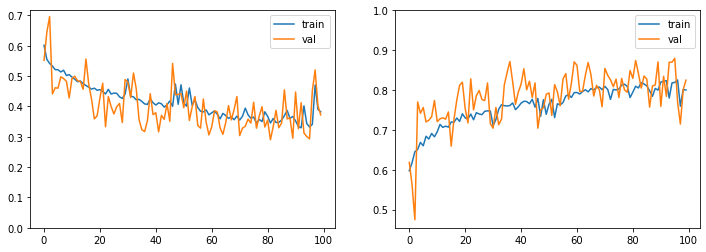

In [27]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4151 - accuracy: 0.7818 - precision: 0.9921 - recall: 0.7720 - f1: 0.8622 - specificity: 0.8027 - negative_predictive_value: 0.2278 - matthews_correlation_coefficient: 0.3544 - val_loss: 0.3807 - val_accuracy: 0.8387 - val_precision: 0.9643 - val_recall: 0.8136 - val_f1: 0.8811 - val_specificity: 0.7748 - val_negative_predictive_value: 0.2588 - val_matthews_correlation_coefficient: 0.3829

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.38286, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_30-02_10_36.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3224 - accuracy: 0.8698 - precision: 0.9917 - recall: 0.8666 - f1: 0.9230 - specificity: 0.7196 - negative_predictive_value: 0.3117 - matthews_correlation_coefficient: 0.4179 - val_loss: 0.4039 - val_accuracy: 0.8491 - val_precis


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2419 - accuracy: 0.9158 - precision: 0.9932 - recall: 0.9173 - f1: 0.9524 - specificity: 0.8023 - negative_predictive_value: 0.4604 - matthews_correlation_coefficient: 0.5620 - val_loss: 0.1886 - val_accuracy: 0.9376 - val_precision: 0.9635 - val_recall: 0.9180 - val_f1: 0.9398 - val_specificity: 0.7477 - val_negative_predictive_value: 0.4450 - val_matthews_correlation_coefficient: 0.5381

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.55115
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2488 - accuracy: 0.9197 - precision: 0.9918 - recall: 0.9224 - f1: 0.9549 - specificity: 0.7823 - negative_predictive_value: 0.4400 - matthews_correlation_coefficient: 0.5401 - val_loss: 0.2038 - val_accuracy: 0.9384 - val_precision: 0.9635 - val_recall: 0.9189 - val_f1: 0.9402 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2005 - accuracy: 0.9386 - precision: 0.9939 - recall: 0.9377 - f1: 0.9638 - specificity: 0.7611 - negative_predictive_value: 0.5021 - matthews_correlation_coefficient: 0.5830 - val_loss: 0.1303 - val_accuracy: 0.9636 - val_precision: 0.9908 - val_recall: 0.9710 - val_f1: 0.9805 - val_specificity: 0.7658 - val_negative_predictive_value: 0.5948 - val_matthews_correlation_coefficient: 0.6447

Epoch 00029: val_matthews_correlation_coefficient improved from 0.59848 to 0.64469, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_30-02_10_36.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2301 - accuracy: 0.9278 - precision: 0.9891 - recall: 0.9306 - f1: 0.9568 - specificity: 0.7816 - negative_predictive_value: 0.4989 - matthews_correlation_coefficient: 0.5805 - val_loss: 0.3644 - val_accuracy: 0.8942 - val_precision: 0.9669 - val_recall: 0.8696 - val_f1: 0.9149 - val_s


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.64469
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1746 - accuracy: 0.9403 - precision: 0.9942 - recall: 0.9425 - f1: 0.9666 - specificity: 0.7902 - negative_predictive_value: 0.5440 - matthews_correlation_coefficient: 0.6154 - val_loss: 0.1422 - val_accuracy: 0.9575 - val_precision: 0.9673 - val_recall: 0.9352 - val_f1: 0.9506 - val_specificity: 0.8063 - val_negative_predictive_value: 0.6011 - val_matthews_correlation_coefficient: 0.6642

Epoch 00044: val_matthews_correlation_coefficient improved from 0.64469 to 0.66424, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_30-02_10_36.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1627 - accuracy: 0.9538 - precision: 0.9942 - recall: 0.9566 - f1: 0.9745 - specificity: 0.8156 - negative_predictive_value: 0.5999 - matthews_correlation_coefficient: 0.6658 - val_loss: 0.2724

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1434 - accuracy: 0.9544 - precision: 0.9951 - recall: 0.9569 - f1: 0.9749 - specificity: 0.7929 - negative_predictive_value: 0.6069 - matthews_correlation_coefficient: 0.6603 - val_loss: 0.3438 - val_accuracy: 0.8907 - val_precision: 0.9700 - val_recall: 0.8630 - val_f1: 0.9128 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3313 - val_matthews_correlation_coefficient: 0.4800

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1640 - accuracy: 0.9471 - precision: 0.9953 - recall: 0.9483 - f1: 0.9700 - specificity: 0.8495 - negative_predictive_value: 0.5979 - matthews_correlation_coefficient: 0.6767 - val_loss: 0.4156 - val_accuracy: 0.8716 - val_precision: 0.9688 - val_recall: 0.8444 - val_f1: 0.9017 - val_specificity: 0.8266 - val_negative_predictive_value: 0.2989 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1380 - accuracy: 0.9555 - precision: 0.9955 - recall: 0.9576 - f1: 0.9757 - specificity: 0.8283 - negative_predictive_value: 0.5924 - matthews_correlation_coefficient: 0.6659 - val_loss: 0.2782 - val_accuracy: 0.8699 - val_precision: 0.9698 - val_recall: 0.8411 - val_f1: 0.9001 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3008 - val_matthews_correlation_coefficient: 0.4507

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1275 - accuracy: 0.9586 - precision: 0.9964 - recall: 0.9596 - f1: 0.9771 - specificity: 0.8432 - negative_predictive_value: 0.6287 - matthews_correlation_coefficient: 0.6968 - val_loss: 0.1736 - val_accuracy: 0.9228 - val_precision: 0.9959 - val_recall: 0.9228 - val_f1: 0.9576 - val_specificity: 0.8279 - val_negative_predictive_value: 0.4162 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.73890
Epoch 00087: early stopping

   Final Accuracy:  98.01%
  Final Precision:  99.35%
     Final Recall:  98.52%
  Final F-measure:  98.93%
Final Specificity:  90.41%
        Final NPV:  80.49%
        Final MCC:  84.26%
[[  66    7]
 [  16 1064]]
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        73
           1       0.99      0.99      0.99      1080

    accuracy                           0.98      1153
   macro avg       0.90      0.94      0.92      1153
weighted avg       0.98      0.98      0.98      1153



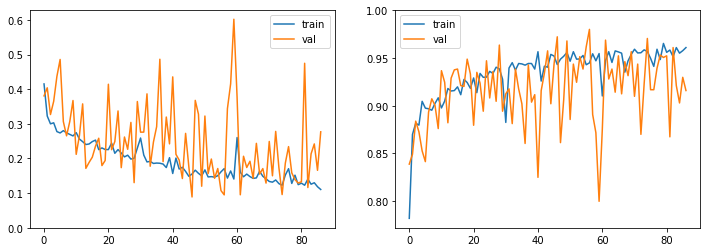

In [28]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6127 - accuracy: 0.6260 - precision: 0.8680 - recall: 0.5804 - f1: 0.6763 - specificity: 0.7701 - negative_predictive_value: 0.4139 - matthews_correlation_coefficient: 0.3162 - val_loss: 0.5625 - val_accuracy: 0.6409 - val_precision: 0.8470 - val_recall: 0.5801 - val_f1: 0.6855 - val_specificity: 0.7575 - val_negative_predictive_value: 0.4175 - val_matthews_correlation_coefficient: 0.2978

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29778, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_30-02_23_48.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5791 - accuracy: 0.6675 - precision: 0.8918 - recall: 0.6264 - f1: 0.7290 - specificity: 0.7788 - negative_predictive_value: 0.4328 - matthews_correlation_coefficient: 0.3625 - val_loss: 0.5619 - val_accuracy: 0.6843 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5432 - accuracy: 0.7111 - precision: 0.8955 - recall: 0.6904 - f1: 0.7736 - specificity: 0.7671 - negative_predictive_value: 0.4669 - matthews_correlation_coefficient: 0.4057 - val_loss: 0.5393 - val_accuracy: 0.6886 - val_precision: 0.8679 - val_recall: 0.6308 - val_f1: 0.7274 - val_specificity: 0.7790 - val_negative_predictive_value: 0.4563 - val_matthews_correlation_coefficient: 0.3634

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.36664
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5452 - accuracy: 0.6972 - precision: 0.8986 - recall: 0.6678 - f1: 0.7601 - specificity: 0.7911 - negative_predictive_value: 0.4658 - matthews_correlation_coefficient: 0.4069 - val_loss: 0.6077 - val_accuracy: 0.6548 - val_precision: 0.8750 - val_recall: 0.5715 - val_f1: 0.6867 - val_specificity: 0.8177 - val_negative_predictive_value: 0.4341 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.37486
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5275 - accuracy: 0.7152 - precision: 0.8967 - recall: 0.6903 - f1: 0.7750 - specificity: 0.7772 - negative_predictive_value: 0.4773 - matthews_correlation_coefficient: 0.4179 - val_loss: 0.5862 - val_accuracy: 0.6852 - val_precision: 0.8433 - val_recall: 0.6485 - val_f1: 0.7301 - val_specificity: 0.7246 - val_negative_predictive_value: 0.4584 - val_matthews_correlation_coefficient: 0.3346

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.37486
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5219 - accuracy: 0.7204 - precision: 0.9014 - recall: 0.6996 - f1: 0.7827 - specificity: 0.7844 - negative_predictive_value: 0.4862 - matthews_correlation_coefficient: 0.4315 - val_loss: 0.5596 - val_accuracy: 0.6869 - val_precision: 0.8687 - val_recall: 0.6269 - val_f1: 0.7248 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.37486
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5127 - accuracy: 0.7278 - precision: 0.9016 - recall: 0.6980 - f1: 0.7819 - specificity: 0.7881 - negative_predictive_value: 0.4899 - matthews_correlation_coefficient: 0.4347 - val_loss: 0.5618 - val_accuracy: 0.6938 - val_precision: 0.8626 - val_recall: 0.6439 - val_f1: 0.7347 - val_specificity: 0.7630 - val_negative_predictive_value: 0.4610 - val_matthews_correlation_coefficient: 0.3618

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.37486
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5131 - accuracy: 0.7232 - precision: 0.9092 - recall: 0.6976 - f1: 0.7852 - specificity: 0.8094 - negative_predictive_value: 0.4897 - matthews_correlation_coefficient: 0.4469 - val_loss: 0.5542 - val_accuracy: 0.6990 - val_precision: 0.8629 - val_recall: 0.6517 - val_f1: 0.7404 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5076 - accuracy: 0.7241 - precision: 0.9083 - recall: 0.6963 - f1: 0.7830 - specificity: 0.7990 - negative_predictive_value: 0.4863 - matthews_correlation_coefficient: 0.4412 - val_loss: 0.5666 - val_accuracy: 0.7034 - val_precision: 0.8628 - val_recall: 0.6596 - val_f1: 0.7449 - val_specificity: 0.7631 - val_negative_predictive_value: 0.4727 - val_matthews_correlation_coefficient: 0.3756

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.38294
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5021 - accuracy: 0.7271 - precision: 0.9087 - recall: 0.7035 - f1: 0.7883 - specificity: 0.7938 - negative_predictive_value: 0.4882 - matthews_correlation_coefficient: 0.4419 - val_loss: 0.5151 - val_accuracy: 0.7207 - val_precision: 0.8554 - val_recall: 0.6972 - val_f1: 0.7660 - val_specificity: 0.7212 - val_negative_predictive_value: 0.4852 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4946 - accuracy: 0.7269 - precision: 0.9058 - recall: 0.7014 - f1: 0.7858 - specificity: 0.7838 - negative_predictive_value: 0.4861 - matthews_correlation_coefficient: 0.4353 - val_loss: 0.5272 - val_accuracy: 0.7199 - val_precision: 0.8636 - val_recall: 0.6838 - val_f1: 0.7613 - val_specificity: 0.7569 - val_negative_predictive_value: 0.4867 - val_matthews_correlation_coefficient: 0.3918

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.39261
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4907 - accuracy: 0.7373 - precision: 0.9141 - recall: 0.7121 - f1: 0.7961 - specificity: 0.8121 - negative_predictive_value: 0.5058 - matthews_correlation_coefficient: 0.4672 - val_loss: 0.5869 - val_accuracy: 0.6843 - val_precision: 0.8607 - val_recall: 0.6318 - val_f1: 0.7254 - val_specificity: 0.7706 - val_negative_predictive_value: 0.4563 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.39408
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4874 - accuracy: 0.7401 - precision: 0.9141 - recall: 0.7144 - f1: 0.7966 - specificity: 0.8223 - negative_predictive_value: 0.5054 - matthews_correlation_coefficient: 0.4740 - val_loss: 0.6264 - val_accuracy: 0.6739 - val_precision: 0.8919 - val_recall: 0.5903 - val_f1: 0.7058 - val_specificity: 0.8509 - val_negative_predictive_value: 0.4525 - val_matthews_correlation_coefficient: 0.3880

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.39408
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4921 - accuracy: 0.7254 - precision: 0.9117 - recall: 0.6975 - f1: 0.7824 - specificity: 0.8096 - negative_predictive_value: 0.4902 - matthews_correlation_coefficient: 0.4513 - val_loss: 0.5348 - val_accuracy: 0.7138 - val_precision: 0.8580 - val_recall: 0.6843 - val_f1: 0.7585 - val_spe

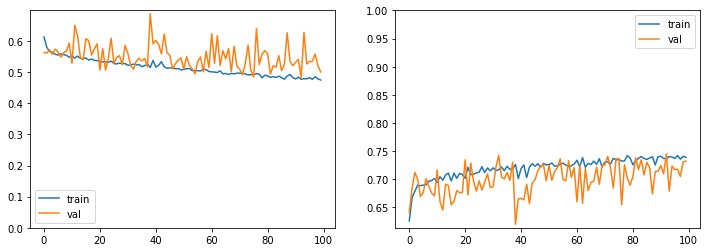

In [29]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4378 - accuracy: 0.7833 - precision: 0.9979 - recall: 0.7838 - f1: 0.8695 - specificity: 0.2563 - negative_predictive_value: 0.0455 - matthews_correlation_coefficient: 0.0875 - val_loss: 0.6699 - val_accuracy: 0.6895 - val_precision: 0.9990 - val_recall: 0.6955 - val_f1: 0.8166 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0284 - val_matthews_correlation_coefficient: 0.0666

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.06659, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_30-02_38_53.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3219 - accuracy: 0.8382 - precision: 0.9993 - recall: 0.8384 - f1: 0.9104 - specificity: 0.2736 - negative_predictive_value: 0.0654 - matthews_correlation_coefficient: 0.1204 - val_loss: 0.1427 - val_accuracy: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2345 - accuracy: 0.8690 - precision: 0.9995 - recall: 0.8657 - f1: 0.9260 - specificity: 0.2862 - negative_predictive_value: 0.0740 - matthews_correlation_coefficient: 0.1319 - val_loss: 0.5913 - val_accuracy: 0.7034 - val_precision: 0.9990 - val_recall: 0.7091 - val_f1: 0.8251 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0289 - val_matthews_correlation_coefficient: 0.0676

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.14195
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2454 - accuracy: 0.8356 - precision: 0.9995 - recall: 0.8354 - f1: 0.9086 - specificity: 0.2897 - negative_predictive_value: 0.0584 - matthews_correlation_coefficient: 0.1167 - val_loss: 0.2685 - val_accuracy: 0.8873 - val_precision: 0.9992 - val_recall: 0.8900 - val_f1: 0.9401 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0886 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2280 - accuracy: 0.8427 - precision: 0.9997 - recall: 0.8424 - f1: 0.9130 - specificity: 0.2931 - negative_predictive_value: 0.0622 - matthews_correlation_coefficient: 0.1215 - val_loss: 0.2430 - val_accuracy: 0.8673 - val_precision: 0.9991 - val_recall: 0.8704 - val_f1: 0.9287 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0851 - val_matthews_correlation_coefficient: 0.1291

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.14195
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2169 - accuracy: 0.8711 - precision: 0.9998 - recall: 0.8708 - f1: 0.9299 - specificity: 0.2690 - negative_predictive_value: 0.0788 - matthews_correlation_coefficient: 0.1296 - val_loss: 0.2213 - val_accuracy: 0.8899 - val_precision: 0.9991 - val_recall: 0.8925 - val_f1: 0.9416 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0883 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2051 - accuracy: 0.8677 - precision: 1.0000 - recall: 0.8671 - f1: 0.9276 - specificity: 0.2966 - negative_predictive_value: 0.0759 - matthews_correlation_coefficient: 0.1363 - val_loss: 0.2667 - val_accuracy: 0.8881 - val_precision: 0.9991 - val_recall: 0.8908 - val_f1: 0.9406 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0874 - val_matthews_correlation_coefficient: 0.1315

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.15302
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2140 - accuracy: 0.8601 - precision: 0.9995 - recall: 0.8600 - f1: 0.9232 - specificity: 0.3000 - negative_predictive_value: 0.0733 - matthews_correlation_coefficient: 0.1337 - val_loss: 0.2406 - val_accuracy: 0.8985 - val_precision: 0.9991 - val_recall: 0.9011 - val_f1: 0.9464 - val_specificity: 0.2432 - val_negative_predictive_value: 0.1059 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1812 - accuracy: 0.8818 - precision: 0.9997 - recall: 0.8816 - f1: 0.9359 - specificity: 0.2759 - negative_predictive_value: 0.0824 - matthews_correlation_coefficient: 0.1385 - val_loss: 0.2009 - val_accuracy: 0.9185 - val_precision: 0.9992 - val_recall: 0.9207 - val_f1: 0.9575 - val_specificity: 0.2432 - val_negative_predictive_value: 0.1122 - val_matthews_correlation_coefficient: 0.1530

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.15302
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1926 - accuracy: 0.8855 - precision: 0.9995 - recall: 0.8853 - f1: 0.9379 - specificity: 0.2759 - negative_predictive_value: 0.0819 - matthews_correlation_coefficient: 0.1352 - val_loss: 0.4028 - val_accuracy: 0.8127 - val_precision: 0.9991 - val_recall: 0.8165 - val_f1: 0.8962 - val_specificity: 0.2432 - val_negative_predictive_value: 0.0467 - val_matthews_correlation_coefficie

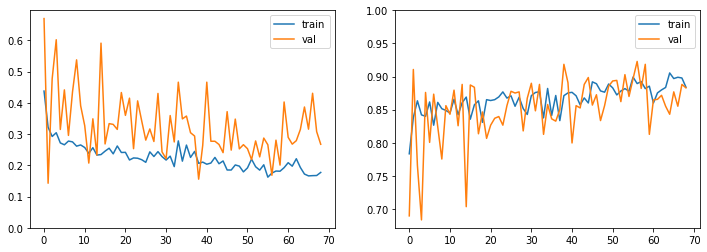

In [30]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

# Models Merge

In [31]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [32]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_03_29-22_13_39.h5'
 '../models/autoencoders_requirements/looking_away_2020_03_29-22_28_37.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_03_29-22_39_14.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_03_29-22_54_02.h5'
 '../models/autoencoders_requirements/washed_out_2020_03_29-23_01_11.h5'
 '../models/autoencoders_requirements/pixelation_2020_03_29-23_10_21.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_03_29-23_19_28.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_03_29-23_34_18.h5'
 '../models/autoencoders_requirements/varied_background_2020_03_29-23_44_25.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_03_29-23_59_19.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_30-00_11_34.h5'
 '../models/autoencoders_requirements/red_eyes_2020_03_30-00_26_31.h5'
 '../models/autoencoders_requirements/shadows_behind_head_2020_03_30-00_41_26.h5'


In [33]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [34]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

In [35]:
merged_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [36]:
import cv2
from glob import glob

# list_files = glob('../data/pybossa/images/*')
list_files = ['../data/pybossa/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../data/pybossa/images/AR_FDB_m-013-17.png
1 of 1


[array([[0.9999926]], dtype=float32),
 array([[0.77948964]], dtype=float32),
 array([[0.9828776]], dtype=float32),
 array([[0.959529]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9985814]], dtype=float32),
 array([[0.82486117]], dtype=float32),
 array([[0.71261996]], dtype=float32),
 array([[0.6448757]], dtype=float32),
 array([[0.8694878]], dtype=float32),
 array([[0.7621494]], dtype=float32),
 array([[0.66698515]], dtype=float32),
 array([[0.9998679]], dtype=float32),
 array([[0.99712604]], dtype=float32),
 array([[0.9751409]], dtype=float32),
 array([[0.3404103]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.81591856]], dtype=float32),
 array([[0.99999595]], dtype=float32),
 array([[0.999801]], dtype=float32),
 array([[0.64612687]], dtype=float32),
 array([[1.]], dtype=float32)]